In [4]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm, ttest_ind_from_stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import imageio

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.analysis.align import ImageAlign
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

from lib.utilities import *
from lib.file.TIF import *

from ZDA_Adventure.utility import ROIFileReader

try:
    from PPR_PV_anna_Dec2025_progress import rec_id_skip_list
except ImportError:
    rec_id_skip_list = []


In [5]:
rec_id_skip_list

[]

In [6]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_PVCre/"
camera_program = 4
which_rig = 'old'  # change to 'old' for old rig dic alignment
date_format = 'yy-mm-dd'
if which_rig == 'old':
    date_format = 'yyyy-mm-dd'

# annotation settings
skip_draw_annotations = False  # If True, don't draw any new annotations
disable_annotations = True  # If True, don't draw any annotations

rois_files_to_choose = ['L23', 'L4', "L5"] # choose a set of rois for each of these layer labels
roi_selector_size = 4 # number of pixels to select at a time when choosing rois

exclude_distant_neighbors = True  # whether to exclude distant neighbors from analysis

In [7]:
'''def show_tiff(path, save=True, show=False ):
    image = imageio.imread(path)
    # imshow the original image
    plt.clf()
    plt.imshow(image, cmap='gray')
    plt.title(path.split('/')[-1])
    if save:
        plt.savefig(path.replace(".tif", "_original") + '.png')  
    if show:   
        plt.show()

def delete_8bit(path, allowed_extensions=('.tif', '.tiff', '.png', '.jpg', '.jpeg')):
    if os.path.exists(path) and '_8bit' in path and any(path.endswith(ext) for ext in allowed_extensions):
        os.remove(path)
        print('Deleted:', path)

def archive_file(path, archive_dir="archive"):
    if not os.path.exists(archive_dir):
        os.makedirs(archive_dir)
    if os.path.exists(path):
        shutil.move(path, os.path.join(archive_dir, os.path.basename(path)))
        print('Archived:', path)

from tifffile import TiffFileError
# loop through all files in data_dir and convert 16-bit tiffs to 8-bit tiffs
for root, dirs, files in os.walk(data_dir):
    for file in files:
        full_path = os.path.join(root, file)
        if 'archive' in full_path:
            continue  # skip files in archive directories
        if file.endswith(".tif") and "_8bit" not in file:
            print('Converting:', file)
            
            try:
                show_tiff(full_path)
            except TiffFileError as e:
                print('Error opening file:', full_path, e)

            # archive the original 16-bit file
            if 'original' not in full_path:
                arch_dir = os.path.join(root, "archive")
                print('Archiving to:', arch_dir)
                try:
                    archive_file(full_path, arch_dir)
                except Exception as e:
                    print('Error archiving file:', full_path, e)
            
        # delete the 8-bit version if it exists
        delete_8bit(full_path)

        


'''

'def show_tiff(path, save=True, show=False ):\n    image = imageio.imread(path)\n    # imshow the original image\n    plt.clf()\n    plt.imshow(image, cmap=\'gray\')\n    plt.title(path.split(\'/\')[-1])\n    if save:\n        plt.savefig(path.replace(".tif", "_original") + \'.png\')  \n    if show:   \n        plt.show()\n\ndef delete_8bit(path, allowed_extensions=(\'.tif\', \'.tiff\', \'.png\', \'.jpg\', \'.jpeg\')):\n    if os.path.exists(path) and \'_8bit\' in path and any(path.endswith(ext) for ext in allowed_extensions):\n        os.remove(path)\n        print(\'Deleted:\', path)\n\ndef archive_file(path, archive_dir="archive"):\n    if not os.path.exists(archive_dir):\n        os.makedirs(archive_dir)\n    if os.path.exists(path):\n        shutil.move(path, os.path.join(archive_dir, os.path.basename(path)))\n        print(\'Archived:\', path)\n\nfrom tifffile import TiffFileError\n# loop through all files in data_dir and convert 16-bit tiffs to 8-bit tiffs\nfor root, dirs, files

In [8]:
verbose = False
# First ask user to annotate some images with Electrode loc and L4 boundaries and layer text placement
# based on DIC-to-ZDA_Alignment script
for subdir, dirs, files in os.walk(data_dir):
    if disable_annotations:
        continue
    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'archive' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/archive/"
        selected_zda_dir = subdir + "/"
        already_drawn_slic_loc = {}
        
        # optionally process date
        date = ""
        try:
            char_select = -len(date_format)
            date = subdir.split("_Usable")[0][char_select:]
            date = [int(x) for x in date.split("-")]
            if date_format != 'yyyy-mm-dd':
                date[2] += 2000  # full year format
            else:
                date = [date[1], date[2], date[0]]
            date = "/".join([str(d) for d in date])
        except Exception as e:
            print(e, "could not process date.")

        # take selected zda and expand into separate subdir for each zda file
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                if subdir+rec_id in rec_id_skip_list:
                    continue
                if subdir in rec_id_skip_list:
                    continue  # skip entire subdir, manually added
                print("\n", subdir)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                print("Processing:", slic_id, loc_id)
                # output dir
                output_dir = selected_zda_dir + "/analysis" + rec_id + "/"
                try:
                    os.makedirs(output_dir)
                except Exception as e:
                    pass

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id,
                                                      verbose=verbose)

                # align RLI and DIC and record the RLI's image boundaries within the DIC image.
                img_aligner = ImageAlign(rig=which_rig)

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)

                        # if already drawn, no need to ask user again
                        if str(slic_id)+"_"+str(loc_id) in already_drawn_slic_loc:
                            # just copy them over
                            src_dir = already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)]
                            electrode_file = src_dir + "electrode.dat"
                            roi_layer_files = [src_dir + "rois_layer_" + layer_label + ".dat" for layer_label in rois_files_to_choose]

                            # copy if exists
                            if os.path.exists(electrode_file):
                                shutil.copy(electrode_file, output_dir + "electrode.dat")
                            for i, roi_file in enumerate(roi_layer_files):
                                layer_label = rois_files_to_choose[i]
                                roi_file_output = output_dir + "rois_layer_" + layer_label + ".dat"
                                if os.path.exists(roi_file):
                                    shutil.copy(roi_file, roi_file_output)

                            print("Copied previous annotations over.")
                            continue

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor
                            
                        if which_rig != 'new':
                            fluor = dic_electrode

                        dic_electrode = np.array(dic_electrode, dtype=np.uint16)
                        orig_arr_shape = dic_electrode.shape

                        # renormalize to 0-255 for drawing
                        dic_electrode = ((dic_electrode - np.min(dic_electrode)) / (np.max(dic_electrode) - np.min(dic_electrode)) * 255).astype(np.uint8)
                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)

                        # ask user to select site of stim and layer/barrel borders
                        electrode_file = output_dir + "electrode.dat"
                        roi_layer_files = [output_dir + "rois_layer_" + layer_label + ".dat" for layer_label in rois_files_to_choose]

                        if not skip_draw_annotations:
                            dic_electrode, coords_electrode, rois_img_coord_dict = \
                                img_aligner.draw_on_images_wrapper_2(
                                    dic_electrode, 
                                    fluor, 
                                    date + " " + rec_id + " ",
                                    roi_layer_files,
                                    brush_size=20)

                            ###### show electrode #######
                            plt.imshow(dic_electrode, cmap='gray')
                            x_el, y_el = coords_electrode['electrode']
                            plt.plot(x_el, y_el, marker="*", color='red')
                            dcs = []
                            if which_rig != 'new':  # show the portion of frame which is PhotoZ
                                photoZ_frame_coords = img_aligner.dic_coordinates
                                for dc_c in photoZ_frame_coords:
                                    x_c = dc_c[0] * dic_electrode.shape[1]
                                    y_c = dc_c[1] * dic_electrode.shape[0]
                                    dcs.append([x_c, y_c])
                                for ic, jc in [[0,1],[1,3],[3,2],[2,0]]:
                                    plt.plot([dcs[ic][0], dcs[jc][0]], [dcs[ic][1], dcs[jc][1]], 
                                             color="white", 
                                             linewidth=3)
                            plt.show()

                            ###### show barrel ROIs layer-by-layer #######
                            roi_coords = {}
                            for layer_label in rois_img_coord_dict:
                                img_roi, coord_roi = rois_img_coord_dict[layer_label]
                                roi_coords[layer_label] = coord_roi
                                plt.imshow(img_roi, cmap='gray')
                                print("Layer:", layer_label)
                                
                            if which_rig != 'new':  # show the portion of frame which is PhotoZ
                                photoZ_frame_coords = img_aligner.dic_coordinates
                                for ic, jc in [[0,1],[1,3],[3,2],[2,0]]:
                                    plt.plot([dcs[ic][0], dcs[jc][0]], [dcs[ic][1], dcs[jc][1]], 
                                             color="white", 
                                             linewidth=3)
                                plt.show()

                            try:
                                os.makedirs(output_dir)
                            except OSError:
                                pass
                            print(roi_coords)
                            # transform coordinates -- Actual alignment work done here
                            print("\n \tcoords_electrode", coords_electrode)
                            coords_electrode = img_aligner.transform_from_dic_coordinates(coords_electrode, orig_arr_shape)
                            coords_rois = img_aligner.transform_from_dic_coordinates(roi_coords, orig_arr_shape, multi_pt_rois=True)
                            # combine coordinate dictionaries
                            for k in coords_electrode:
                                coords_rois[k] = coords_electrode[k]

                            print(coords_rois.keys())

                            # write electrode and corners to file
                            img_aligner.write_shapes_to_files_rois(coords_rois,
                                                                  electrode_file)
                            print("Wrote files to", output_dir)

                        # mark this slice/loc already drawn 
                        already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)] = output_dir
                image_data.clear()
                rec_id_skip_list.append(subdir+rec_id)
rec_id_skip_list

[]

In [9]:
# auto-merge ROIs and rewrite file
lock = True
if not lock:
    roi_writer = ROIFileWriter()
    for subdir, dirs, files in os.walk(data_dir):
        if 'analysis' not in subdir:
            continue
        for file in files:
            if not file.endswith('.dat'):
                continue
            
            # read in ROIs
            rois = ROIFileReader(subdir + "/" + file, convert_diode_nums=False)
            n_rois_before = len(rois.get_roi_list())
            rois.merge_overlapping_rois()
            rois = rois.get_roi_list()
            if len(rois) < n_rois_before:
                print(f"Merged {n_rois_before} -> {len(rois)} overlapping ROIs in {subdir + '/' + file}")

            # rewrite to file
            roi_writer.write_regions_to_dat(subdir + "/" + file, rois)



In [10]:
# visualize all annotations to verify
verbose = False
output_visualization_dir = data_dir + "/annotation_visualizations/"
disable_visualizations = True
# First ask user to annotate some images with Electrode loc and L4 boundaries and layer text placement
# based on DIC-to-ZDA_Alignment script
for subdir, dirs, files in os.walk(data_dir):
    if disable_visualizations:
        continue
    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'archive' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/archive/"
        selected_zda_dir = subdir + "/"
        already_drawn_slic_loc = {}
        
        # optionally process date
        date = ""
        try:
            char_select = -len(date_format)
            date = subdir.split("_Usable")[0][char_select:]
            date = [int(x) for x in date.split("-")]
            if date_format != 'yyyy-mm-dd':
                date[2] += 2000  # full year format
            else:
                date = [date[1], date[2], date[0]]
            date = "/".join([str(d) for d in date])
        except Exception as e:
            print(e, "could not process date.")

        # take selected zda and expand into separate subdir for each zda file
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):

                # plt figure with two subplots: dic_electrode and ROIs
                
                rec_id = zda_file.split('.')[0]

                print("\n", subdir)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                print("Processing:", slic_id, loc_id)
                # output dir
                output_dir = selected_zda_dir + "/analysis" + rec_id + "/"
                try:
                    os.makedirs(output_dir)
                except Exception as e:
                    pass

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id,
                                                      verbose=verbose)

                # align RLI and DIC and record the RLI's image boundaries within the DIC image.
                img_aligner = ImageAlign(rig=which_rig)

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)
                        if str(slic_id)+"_"+str(loc_id) in already_drawn_slic_loc:
                            print("Already drew, skipping visualization.")
                            continue
                        already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)] = True
                        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor
                            
                        if which_rig != 'new':
                            fluor = dic_electrode

                        dic_electrode = np.array(dic_electrode, dtype=np.uint16)
                        orig_arr_shape = dic_electrode.shape

                        # renormalize to 0-255 for drawing
                        dic_electrode = ((dic_electrode - np.min(dic_electrode)) / (np.max(dic_electrode) - np.min(dic_electrode)) * 255).astype(np.uint8)
                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)

                        # ask user to select site of stim and layer/barrel borders
                        electrode_file = output_dir + "electrode.dat"
                        roi_layer_files = [output_dir + "rois_layer_" + layer_label + ".dat" for layer_label in rois_files_to_choose]
                        
                        # imshow a blank 80x80 image
                        axs[1].imshow(np.zeros((80, 80)), cmap='gray')

                        axs[0].imshow(dic_electrode, cmap='gray')
                        if os.path.exists(electrode_file):
                            roi_electrode = ROIFileReader(electrode_file)
                            coords_electrode = roi_electrode.get_roi_list()[0]
                            x_el, y_el = coords_electrode[0]
                            ###### show electrode #######                        
                            axs[1].plot(x_el, y_el, marker="*", color='red')

                        dcs = []
                        if which_rig != 'new':  # show the portion of frame which is PhotoZ
                            photoZ_frame_coords = img_aligner.dic_coordinates
                            for dc_c in photoZ_frame_coords:
                                x_c = dc_c[0] * dic_electrode.shape[1]
                                y_c = dc_c[1] * dic_electrode.shape[0]
                                dcs.append([x_c, y_c])
                            for ic, jc in [[0,1],[1,3],[3,2],[2,0]]:
                                axs[0].plot([dcs[ic][0], dcs[jc][0]], [dcs[ic][1], dcs[jc][1]], 
                                            color="white", 
                                            linewidth=3)

                        ##### show barrel ROIs layer-by-layer #######
                        roi_coords = {}

                        # load ROI files and display
                        img_roi = np.zeros((80, 80))                        
                        for i_layer, roi_file in enumerate(roi_layer_files):
                            layer_label = roi_file.split("rois_layer_")[-1].split(".dat")[0]
                            rois = ROIFileReader(roi_file, convert_diode_nums=True)
                            rois_list = rois.get_roi_list()

                            coord_roi = []
                            for i_roi, roi in enumerate(rois_list):
                                for pt in roi:
                                    x_pt, y_pt = pt
                                    img_roi[y_pt, x_pt] = (i_roi + 1) * 10 + 80 * i_layer
                                    coord_roi.append([x_pt, y_pt])
                            roi_coords[layer_label] = coord_roi
                            
                        axs[1].imshow(img_roi, cmap='gray')
                        plt.title(date + " " + rec_id)
                        plt.savefig(output_visualization_dir + date.replace("/", "-") + "_" + str(slic_id) + "_" + str(loc_id) + "_annotations.png")


In [11]:
# load trace files from the following directory
#data_dir = '/home/john/Desktop/'

#export_csv = data_dir + 'export_summary_anna_rois_only_ppr.csv'
data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/'
export_csv = data_dir + 'export_summary_anna_ppr_all_barrels_lat_map.csv'

camera_program = 4
um_per_px = 6.875 #um
output_fig_dir = 'P:/John/pv-ppr-paper/input/'

# load the CSVs
ppr_df = pd.read_csv(export_csv)

# add column for Coronal/Sagittal
ppr_df['Section'] = 'Coronal'

ppr_df

ROI       amp    latency  halfwidth   X_Center   Y_Center  \
0        1  1.207785  50.832063   8.483424  35.750000  44.225460   
1        2  0.904246  43.143071  16.047991  57.468284  30.994403   
2        3  1.212838  51.424012   8.436819  14.868085  58.165957   
3        1  1.035536  70.177967   4.190614  35.750000  44.225460   
4        2  0.693921  65.399529   9.480184  57.468284  30.994403   
...    ...       ...        ...        ...        ...        ...   
23239    2  1.255736  43.000000  12.829395  16.485255  48.501340   
23240    3  1.211582  43.000000  17.754763  58.764550  17.724868   
23241    1  2.503061  73.782214   6.164784  39.472160  33.385301   
23242    2  1.967337  73.313998   7.141040  16.485255  48.501340   
23243    3  1.778750  74.375921   5.328070  58.764550  17.724868   

                                      ROI_Set     Date  Slice  Location  \
0      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1   
1      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1   
2      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1   
3      analysis01_01_01\rois_layer_L23 pulse2   22-9-2      1         1   
4      analysis01_01_01\rois_layer_L23 pulse2   22-9-2      1         1   
...                                       ...      ...    ...       ...   
23239   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3   
23240   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3   
23241   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3   
23242   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3   
23243   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3   

       Recording                                              trace  \
0              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
1              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
2              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
3              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
4              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
...          ...                                                ...   
23239          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23240          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23241          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23242          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23243          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   

                                               amp_array  \
0      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
1      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
2      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
3      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
4      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
...                                                  ...   
23239  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23240  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23241  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23242  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23243  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   

                                           latency_array  stim_time  Section  
0      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal  
1      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal  
2      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal  
3      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250166  Coronal  
4      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250166  Coronal  
...                                                  ...        ...      ...  
23239  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal  
23240  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal  
2324

In [12]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and Stim_Layer columns
ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'Stim_Layer', 'Sex', 'Age']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}-{d}-{int(y)}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df

zda_file  IPI Stim_Layer Sex  \
0     C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   20         L4   M   
1     C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   50         L4   M   
2     C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  100         L4   M   
3     C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  100       L2/3   M   
4     C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   20       L2/3   M   
...                                                 ...  ...        ...  ..   
1481  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   50         L5   F   
1482  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   50       L2/3   F   
1483  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  100       L2/3   F   
1484  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  200       L2/3   F   
1485  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   20       L2/3   F   

      Age    zda_id  Slice  Location  Recording     Date  
0      69  01_01_01      1         1          1   22-9-2  
1      69  01_01_02      1         1          2   22-9-2  
2      69  01_01_03      1         1          3   22-9-2  
3      69  01_02_01      1         2          1   22-9-2  
4      69  01_02_02      1         2          2   22-9-2  
...   ...       ...    ...       ...        ...      ...  
1481   72  07_02_04      7         2          4  23-9-17  
1482   72  07_03_01      7         3          1  23-9-17  
1483   72  07_03_02      7         3          2  23-9-17  
1484   72  07_03_03      7         3          3  23-9-17  
1485   72  07_03_04      7         3          4  23-9-17  

[1486 rows x 10 columns]

In [13]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# for each Date, Slice, Location, Recording in ppr_df, find matching row in ppr_catalog_df and add IPI to ppr_df
ppr_df['IPI'] = np.nan
for index, row in ppr_df.iterrows():
    date = row['Date']
    slice_num = row['Slice']
    location = row['Location']
    recording = row['Recording']
    
    matching_row = ppr_catalog_df[(ppr_catalog_df['Date'] == date) &
                                  (ppr_catalog_df['Slice'] == slice_num) &
                                  (ppr_catalog_df['Location'] == location) &
                                  (ppr_catalog_df['Recording'] == recording)]
    
    if not matching_row.empty:
        ppr_df.at[index, 'IPI'] = matching_row['IPI'].values[0]
        ppr_df.at[index, 'Stim_Layer'] = matching_row['Stim_Layer'].values[0]
        ppr_df.at[index, 'Sex'] = matching_row['Sex'].values[0]
        ppr_df.at[index, 'Age'] = matching_row['Age'].values[0]


ppr_df

ROI       amp    latency  halfwidth   X_Center   Y_Center  \
0        1  1.207785  50.832063   8.483424  35.750000  44.225460   
1        2  0.904246  43.143071  16.047991  57.468284  30.994403   
2        3  1.212838  51.424012   8.436819  14.868085  58.165957   
3        1  1.035536  70.177967   4.190614  35.750000  44.225460   
4        2  0.693921  65.399529   9.480184  57.468284  30.994403   
...    ...       ...        ...        ...        ...        ...   
23239    2  1.255736  43.000000  12.829395  16.485255  48.501340   
23240    3  1.211582  43.000000  17.754763  58.764550  17.724868   
23241    1  2.503061  73.782214   6.164784  39.472160  33.385301   
23242    2  1.967337  73.313998   7.141040  16.485255  48.501340   
23243    3  1.778750  74.375921   5.328070  58.764550  17.724868   

                                      ROI_Set     Date  Slice  Location  \
0      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1   
1      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1   
2      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1   
3      analysis01_01_01\rois_layer_L23 pulse2   22-9-2      1         1   
4      analysis01_01_01\rois_layer_L23 pulse2   22-9-2      1         1   
...                                       ...      ...    ...       ...   
23239   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3   
23240   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3   
23241   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3   
23242   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3   
23243   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3   

       Recording                                              trace  \
0              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
1              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
2              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
3              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
4              1  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
...          ...                                                ...   
23239          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23240          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23241          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23242          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23243          4  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   

                                               amp_array  \
0      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
1      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
2      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
3      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
4      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
...                                                  ...   
23239  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23240  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23241  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23242  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   
23243  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...   

                                           latency_array  stim_time  Section  \
0      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
1      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
2      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
3      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250166  Coronal   
4      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250166  Coronal   
...                                                  ...        ...      ...   
23239  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
23240  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Corona

In [14]:

# label pulse number based on "pulse1" and "pulse2" substring in the "ROI_Set" column
def label_pulse(roi_set):
    if 'pulse1' in roi_set:
        return 1
    elif 'pulse2' in roi_set:
        return 2
    else:
        return None
ppr_df['Pulse_Number'] = ppr_df['ROI_Set'].apply(label_pulse)

# subtract stim_time from latency
ppr_df['latency'] = ppr_df['latency'] - ppr_df['stim_time']

# create a column "ROI label" that extracts the ROI label (the first part before " ") from the "ROI_Set" column
ppr_df['ROI_Label'] = ppr_df['ROI_Set'].apply(lambda x: x.split(' ')[0])

# column called "ROI_Loc" that extracts the ROI location (the part after the last "rois_layer_" in the "ROI_Set" column)
ppr_df['ROI_Loc'] = ppr_df['ROI_Set'].apply(lambda x: x.split('rois_layer_')[-1])

# column called "ROI_Loc" that extracts the ROI location (the part after the last "rois_layer_" in the "ROI_Set" column)
ppr_df['ROI_Loc'] = ppr_df['ROI_Set'].apply(lambda x: x.split('rois_layer_')[-1].split(' ')[0].replace("23", "2/3"))
ppr_df

ROI       amp   latency  halfwidth   X_Center   Y_Center  \
0        1  1.207785  1.581981   8.483424  35.750000  44.225460   
1        2  0.904246 -6.107012  16.047991  57.468284  30.994403   
2        3  1.212838  2.173929   8.436819  14.868085  58.165957   
3        1  1.035536  0.927802   4.190614  35.750000  44.225460   
4        2  0.693921 -3.850636   9.480184  57.468284  30.994403   
...    ...       ...       ...        ...        ...        ...   
23239    2  1.255736 -6.250083  12.829395  16.485255  48.501340   
23240    3  1.211582 -6.250083  17.754763  58.764550  17.724868   
23241    1  2.503061  4.531635   6.164784  39.472160  33.385301   
23242    2  1.967337  4.063418   7.141040  16.485255  48.501340   
23243    3  1.778750  5.125342   5.328070  58.764550  17.724868   

                                      ROI_Set     Date  Slice  Location  ...  \
0      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1  ...   
1      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1  ...   
2      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1  ...   
3      analysis01_01_01\rois_layer_L23 pulse2   22-9-2      1         1  ...   
4      analysis01_01_01\rois_layer_L23 pulse2   22-9-2      1         1  ...   
...                                       ...      ...    ...       ...  ...   
23239   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3  ...   
23240   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3  ...   
23241   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3  ...   
23242   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3  ...   
23243   analysis07_03_04\rois_layer_L5 pulse2  23-9-17      7         3  ...   

                                           latency_array  stim_time  Section  \
0      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
1      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
2      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
3      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250166  Coronal   
4      C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250166  Coronal   
...                                                  ...        ...      ...   
23239  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
23240  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  49.250083  Coronal   
23241  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250579  Coronal   
23242  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250579  Coronal   
23243  C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...  69.250579  Coronal   

        IPI  Stim_Layer Sex   Age Pulse_Number  \
0      20.0          L4   M  69.0            1   
1      20.0          L4   M  69.0            1   
2      20.0          L4   M  69.0            1   
3      20.0          L4   M  69.0            2   
4      20.0          L4   M  69.0            2   
...     ...         ...  ..   ...          ...   
23239  20.0        L2/3   F  72.0            1   
23240  20.0        L2/3   F  72.0            1   
23241  20.0        L2/3   F  72.0            2   
23242  20.0        L2/3   F  72.0            2   
23243  20.0        L2/3   F  72.0            2   

                             ROI_Label  ROI_Loc  
0      analysis01_01_01\rois_layer_L23     L2/3  
1      analysis01_01_01\rois_layer_L23     L2/3  
2      analysis01_01_01\rois_layer_L23     L2/3  
3      analysis01_01_01\rois_layer_L23     L2/3  
4      analysis01_01_01\rois_layer_L23     L2/3  
...                                ...      ...  
23239   analysis07_03_04\rois_layer_L5       L5  
23240   analysis07_03_04\rois_layer_L5       L5  
23241   analysis07_03_04\rois_layer_L5       L5  
23242   analysis07_03_04\rois_layer_L5       L5  
23243   analysis07_03_04\rois_layer_L5       L5  

[23244 rows x 23 columns]

In [15]:
ppr_df['PPR'] = np.nan
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]
                for roi_lab in recording_df['ROI_Label'].unique():
                    roi_lab_df = recording_df[recording_df['ROI_Label'] == roi_lab]
                    for roi in roi_lab_df['ROI'].unique():
                        roi_df = roi_lab_df[roi_lab_df['ROI'] == roi]
                        if len(roi_df) < 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has less than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        if len(roi_df) > 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has more than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        pulse1_df = roi_df[roi_df['Pulse_Number'] == 1]
                        pulse2_df = roi_df[roi_df['Pulse_Number'] == 2]
                        ppr = pulse2_df['amp'].values[0] / pulse1_df['amp'].values[0] if \
                            pulse1_df['amp'].values[0] != 0 else np.nan
                        ppr_df.loc[roi_df.index, 'PPR'] = ppr
ppr_df['PPR'] = ppr_df['PPR'].astype(float)

# repeat for paired pulse latency (PPL) and paired pulse halfwidth (PPHW)
ppr_df['PPL'] = np.nan
ppr_df['PPHW'] = np.nan
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]
                for roi_lab in recording_df['ROI_Label'].unique():
                    roi_lab_df = recording_df[recording_df['ROI_Label'] == roi_lab]
                    for roi in roi_lab_df['ROI'].unique():
                        roi_df = roi_lab_df[roi_lab_df['ROI'] == roi]
                        if len(roi_df) < 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has less than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        if len(roi_df) > 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has more than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        pulse1_df = roi_df[roi_df['Pulse_Number'] == 1]
                        pulse2_df = roi_df[roi_df['Pulse_Number'] == 2]
                        
                        if pulse1_df['latency'].values[0] > 0 and pulse2_df['latency'].values[0] >= 0:
                            ppl = pulse2_df['latency'].values[0] - pulse1_df['latency'].values[0]
                            ppr_df.loc[roi_df.index, 'PPL'] = ppl
                        
                        if pulse1_df['halfwidth'].values[0] > 0 and pulse2_df['halfwidth'].values[0] >= 0:
                            pphw = pulse2_df['halfwidth'].values[0] - pulse1_df['halfwidth'].values[0]
                            ppr_df.loc[roi_df.index, 'PPHW'] = pphw

# add a column "Home_Neighbor" that is "Home" if ROI == 1 else "Neighbor"
ppr_df['Home_Neighbor'] = ppr_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')

# concatenate Home_Neighbor + ROI_Loc to make a new column "HN_ROI_Loc" to avoid collinearity
ppr_df['HN_ROI_Loc'] = ppr_df['Home_Neighbor'] + "_" + ppr_df['ROI_Loc']

In [16]:
# use geometry to distinguish between immediate and distant neighbors
# immediate neighbors are directly adjacent to the home barrel, in the same layer
# distant neighbors are adjacent to the immediate neighbors, but not the home barrel, in the same layer
def label_immediate_distant(home_xy, neighbor_xy_list):
    # draw a vector from home_xy to first neighbor
    # for each neighbor, calculate displacement to home_xy projected onto that vector
    # the immediate neighbors are 1 with the shortest positive displacement along that vector,
    # and one with the shortest negative displacement along that vector
    if len(neighbor_xy_list) < 1:
        return [], []
    neighbors = {}
    vector_axis = np.array(neighbor_xy_list[0]) - np.array(home_xy)
    vector = vector_axis / np.linalg.norm(vector_axis)
    for neighbor_xy in neighbor_xy_list:
        vector = np.array(neighbor_xy) - np.array(home_xy)
        disp = np.dot(vector, vector_axis)
        neighbors[disp] = neighbor_xy
    sorted_disp = sorted(neighbors.keys())

    immediate_neighbor_positive = None
    immediate_neighbor_negative = None
    min_disp_positive = float('inf')
    max_disp_negative = float('-inf')
    distant_neighbors = []
    for disp in sorted_disp:
        if disp > 0 and disp < min_disp_positive:
            min_disp_positive = disp
            immediate_neighbor_positive = neighbors[disp]
        if disp < 0 and disp > max_disp_negative:
            max_disp_negative = disp
            immediate_neighbor_negative = neighbors[disp]
    # the rest are distant neighbors
    for disp in sorted_disp:
        if (disp != min_disp_positive) and (disp != max_disp_negative):
            distant_neighbors.append(neighbors[disp])

    immediate_neighbors = [immediate_neighbor_negative, immediate_neighbor_positive]
    return immediate_neighbors, distant_neighbors

# create columns "Neighbor_Type"
ppr_df['Neighbor_Type'] = ''
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]
                for roi_lab in recording_df['ROI_Label'].unique():
                    roi_lab_df = recording_df[recording_df['ROI_Label'] == roi_lab]
                    home_roi = roi_lab_df[roi_lab_df['Home_Neighbor'] == 'Home']
                    if len(home_roi) == 0:
                        continue
                    home_x = home_roi['X_Center'].values[0]
                    home_y = home_roi['Y_Center'].values[0]
                    neighbor_rois = roi_lab_df[roi_lab_df['Home_Neighbor'] == 'Neighbor']
                    neighbor_xy_list = []
                    for index, neighbor_row in neighbor_rois.iterrows():
                        neighbor_x = neighbor_row['X_Center']
                        neighbor_y = neighbor_row['Y_Center']
                        neighbor_xy_list.append([neighbor_x, neighbor_y])
                    immediate_neighbors, distant_neighbors = label_immediate_distant([home_x, home_y], neighbor_xy_list)
                    for index, neighbor_row in neighbor_rois.iterrows():
                        neighbor_x = neighbor_row['X_Center']
                        neighbor_y = neighbor_row['Y_Center']
                        if [neighbor_x, neighbor_y] in immediate_neighbors:
                            ppr_df.at[index, 'Neighbor_Type'] = 'Immediate'
                        elif [neighbor_x, neighbor_y] in distant_neighbors:
                            ppr_df.at[index, 'Neighbor_Type'] = 'Distant'

# filter to only pulse number 1 for further analysis (to avoid double counting)
ppr_df_pulse_2 = ppr_df[ppr_df['Pulse_Number'] == 2]
ppr_df = ppr_df[ppr_df['Pulse_Number'] == 1]

if exclude_distant_neighbors:
    ppr_df = ppr_df[ppr_df['Neighbor_Type'] != 'Distant']

ppr_df

ROI       amp   latency  halfwidth   X_Center   Y_Center  \
0        1  1.207785  1.581981   8.483424  35.750000  44.225460   
1        2  0.904246 -6.107012  16.047991  57.468284  30.994403   
2        3  1.212838  2.173929   8.436819  14.868085  58.165957   
6        1  1.374105  0.851873   5.340682  57.374093  60.941969   
7        2  1.505428  1.048063   5.344480  29.221622  74.210811   
...    ...       ...       ...        ...        ...        ...   
23233    2  1.239652  0.434183  10.475776  30.554455  69.541254   
23234    3  1.067727 -6.250083  18.320869  68.102941  43.676471   
23238    1  1.102175 -6.250083  18.100017  39.472160  33.385301   
23239    2  1.255736 -6.250083  12.829395  16.485255  48.501340   
23240    3  1.211582 -6.250083  17.754763  58.764550  17.724868   

                                      ROI_Set     Date  Slice  Location  ...  \
0      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1  ...   
1      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1  ...   
2      analysis01_01_01\rois_layer_L23 pulse1   22-9-2      1         1  ...   
6       analysis01_01_01\rois_layer_L4 pulse1   22-9-2      1         1  ...   
7       analysis01_01_01\rois_layer_L4 pulse1   22-9-2      1         1  ...   
...                                       ...      ...    ...       ...  ...   
23233   analysis07_03_04\rois_layer_L4 pulse1  23-9-17      7         3  ...   
23234   analysis07_03_04\rois_layer_L4 pulse1  23-9-17      7         3  ...   
23238   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3  ...   
23239   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3  ...   
23240   analysis07_03_04\rois_layer_L5 pulse1  23-9-17      7         3  ...   

        Age Pulse_Number                        ROI_Label ROI_Loc       PPR  \
0      69.0            1  analysis01_01_01\rois_layer_L23    L2/3  0.857385   
1      69.0            1  analysis01_01_01\rois_layer_L23    L2/3  0.767403   
2      69.0            1  analysis01_01_01\rois_layer_L23    L2/3  0.957096   
6      69.0            1   analysis01_01_01\rois_layer_L4      L4  0.936218   
7      69.0            1   analysis01_01_01\rois_layer_L4      L4  1.080298   
...     ...          ...                              ...     ...       ...   
23233  72.0            1   analysis07_03_04\rois_layer_L4      L4  4.239518   
23234  72.0            1   analysis07_03_04\rois_layer_L4      L4  2.193312   
23238  72.0            1   analysis07_03_04\rois_layer_L5      L5  2.271020   
23239  72.0            1   analysis07_03_04\rois_layer_L5      L5  1.566681   
23240  72.0            1   analysis07_03_04\rois_layer_L5      L5  1.468122   

            PPL       PPHW Home_Neighbor     HN_ROI_Loc  Neighbor_Type  
0     -0.654179  -4.292810          Home      Home_L2/3                 
1           NaN  -6.567807      Neighbor  Neighbor_L2/3      Immediate  
2           NaN   6.511618      Neighbor  Neighbor_L2/3      Immediate  
6     -0.485513  -0.143439          Home        Home_L4                 
7     -0.551765  -0.547563      Neighbor    Neighbor_L4      Immediate  
...         ...        ...           ...            ...            ...  
23233  4.208155  -6.207651      Neighbor    Neighbor_L4      Immediate  
23234       NaN -13.532803      Neighbor    Neighbor_L4      Immediate  
23238       NaN -11.935233          Home        Home_L5                 
23239       NaN  -5.688355      Neighbor    Neighbor_L5      Immediate  
23240       NaN -12.426693      Neighbor    Neighbor_L5      Immediate  

[10508 rows x 29 columns]

In [17]:
# count number of Date-Slice combinations
date_slice_combos = ppr_df[['Date', 'Slice']].drop_duplicates()
num_date_slice_combos = len(date_slice_combos)

# count number of Date-Slice-Location combinations
date_slice_location_combos = ppr_df[['Date', 'Slice', 'Location']].drop_duplicates()
num_date_slice_location_combos = len(date_slice_location_combos)

# count number of Date-Slice-Location-ROI combinations
date_slice_location_roi_combos = ppr_df[['Date', 'Slice', 'Location', 'ROI']].drop_duplicates()
num_date_slice_location_roi_combos = len(date_slice_location_roi_combos)

print(f"Number of unique Date-Slice combinations: {num_date_slice_combos}")
print(f"Number of unique Date-Slice-Location combinations: {num_date_slice_location_combos}")
print(f"Number of unique Date-Slice-Location-ROI combinations: {num_date_slice_location_roi_combos}")

# count number of immediate and distant neighbors
immediate_neighbors = ppr_df[ppr_df['Neighbor_Type'] == 'Immediate']
distant_neighbors = ppr_df[ppr_df['Neighbor_Type'] == 'Distant']
print(f"Number of immediate neighbors: {len(immediate_neighbors)}")
print(f"Number of distant neighbors: {len(distant_neighbors)}")

Number of unique Date-Slice combinations: 142
Number of unique Date-Slice-Location combinations: 392
Number of unique Date-Slice-Location-ROI combinations: 1024
Number of immediate neighbors: 6273
Number of distant neighbors: 0


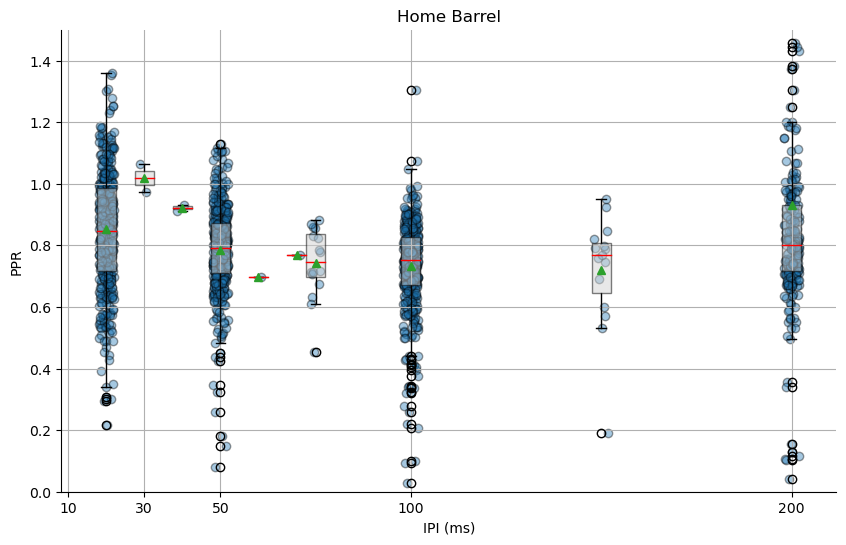

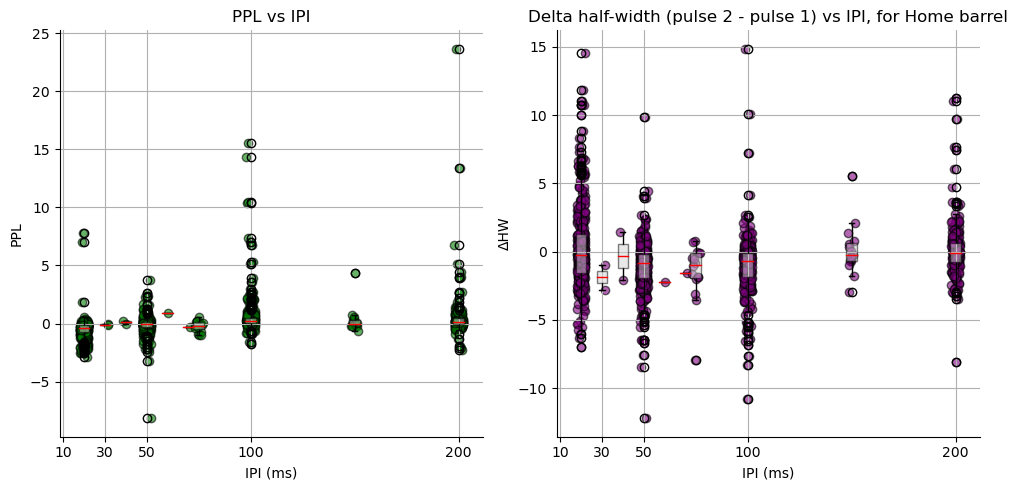

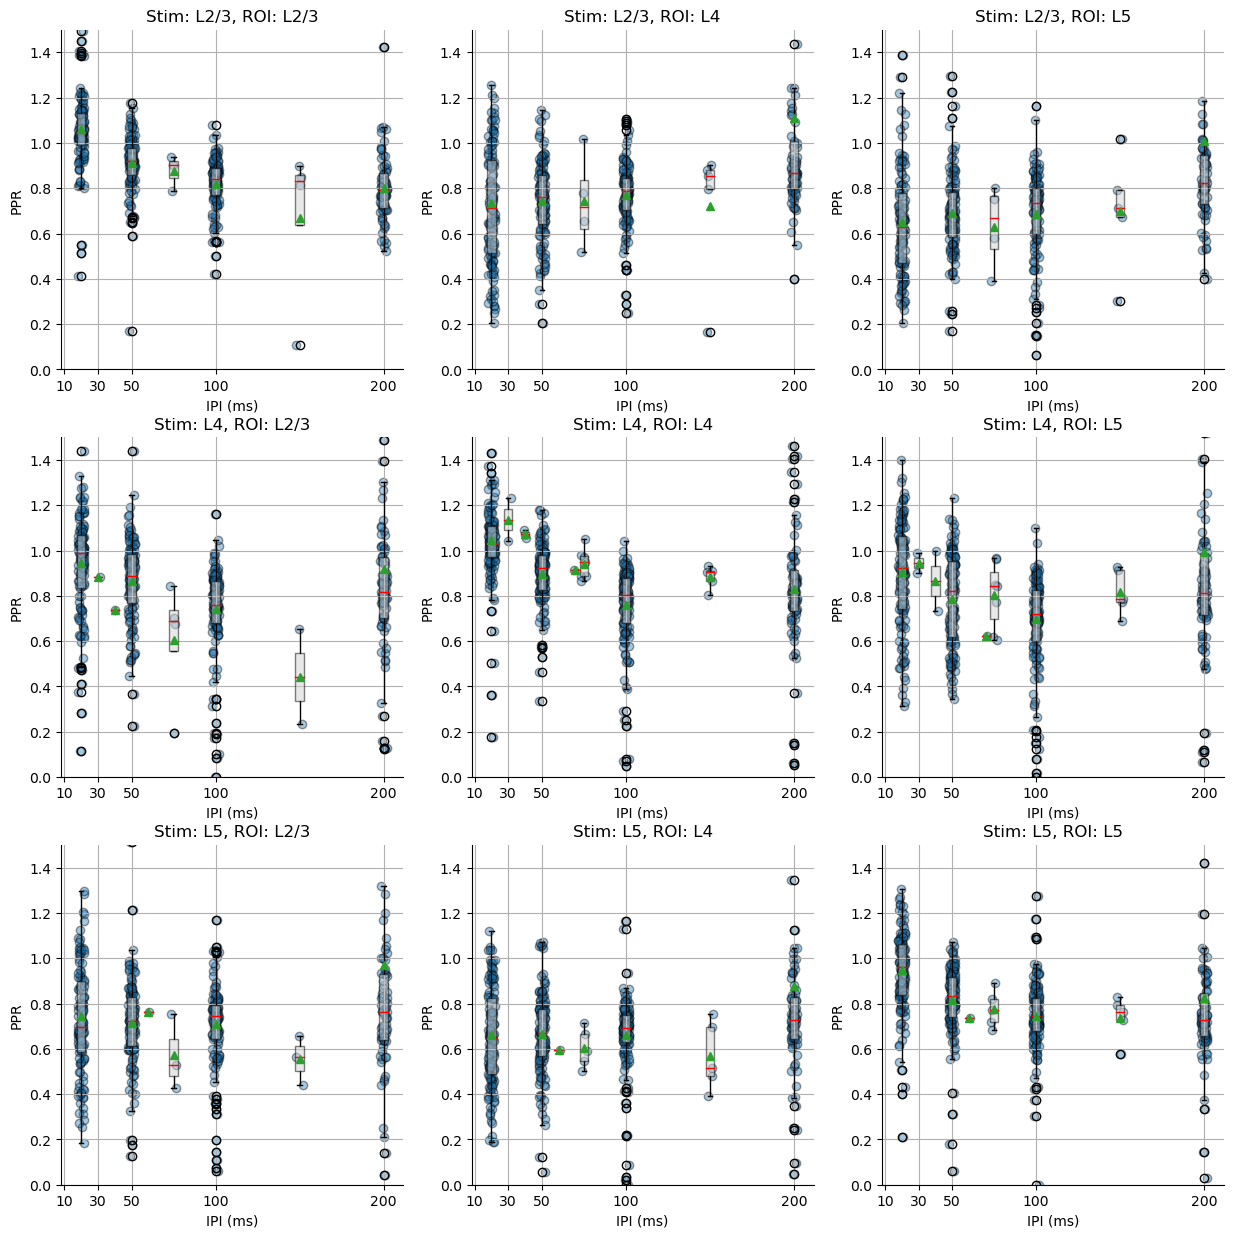

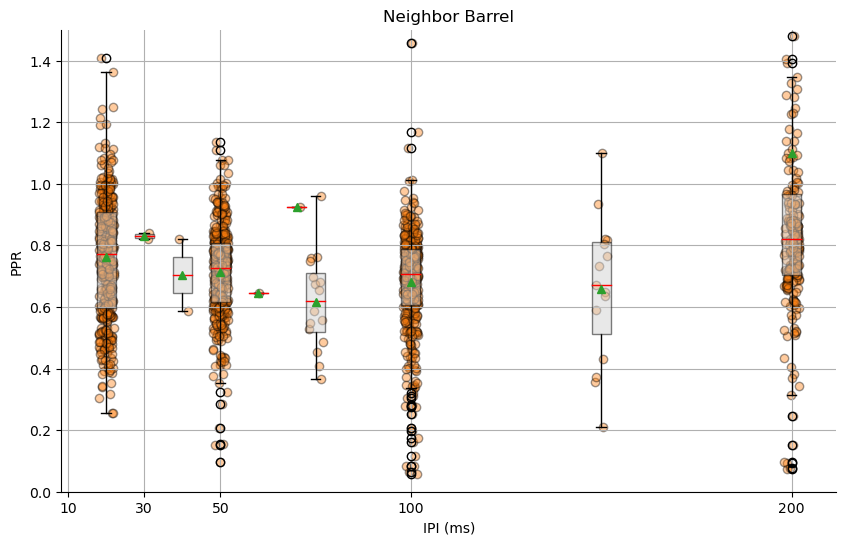

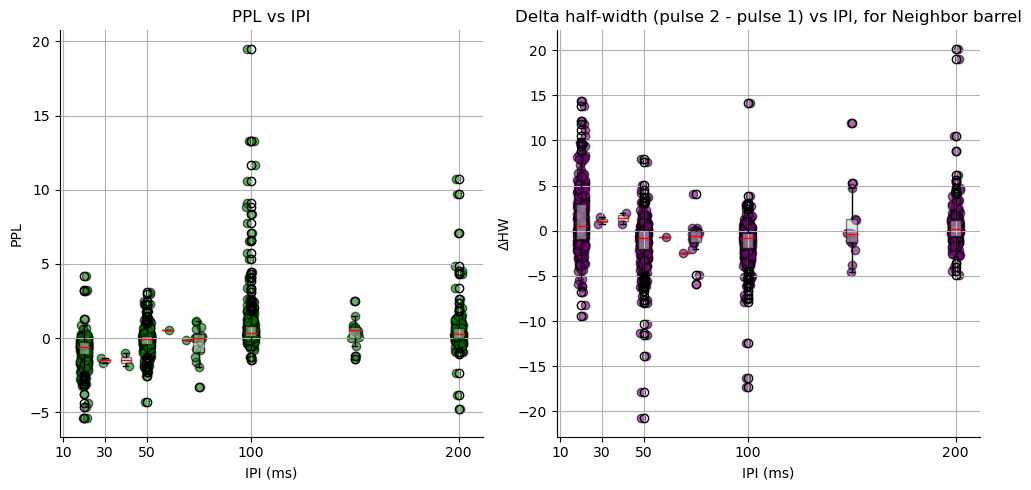

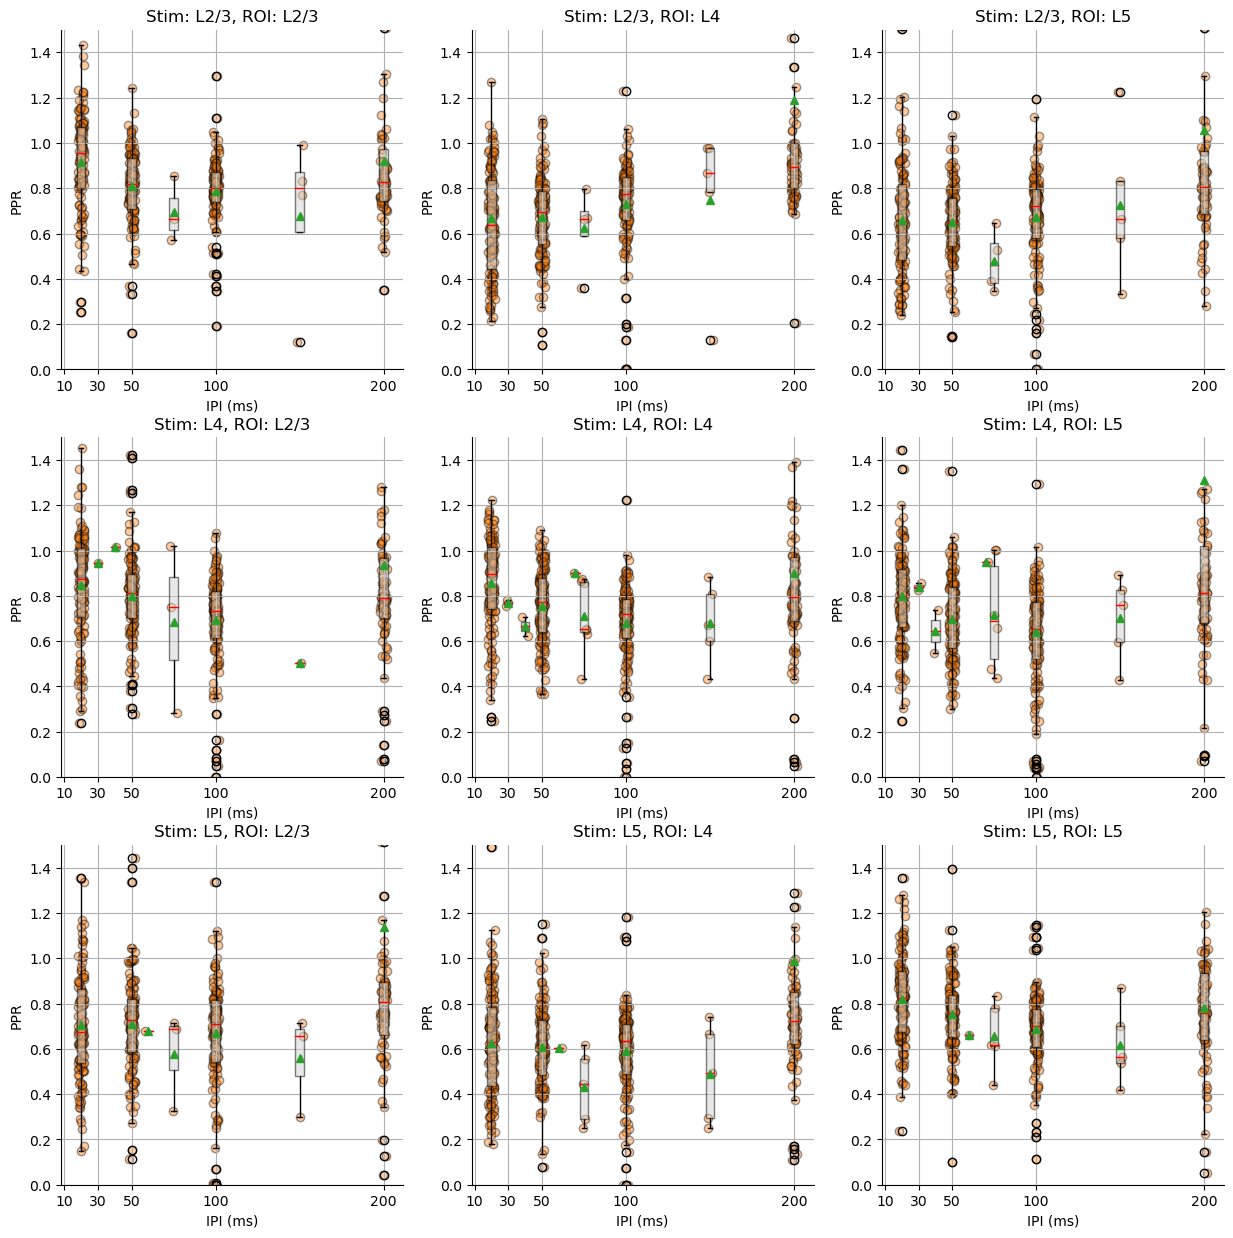

In [18]:

exclude_10ms = True
if exclude_10ms:
    ppr_df = ppr_df[ppr_df['IPI'] != 10]

for home_neighbor in ['Home', 'Neighbor']:

    if home_neighbor == 'Home':
        hn_df = ppr_df[ppr_df['ROI'] == 1]
    else:
        hn_df = ppr_df[ppr_df['ROI'] > 1]
    # plot scatter plot of PPR vs IPI
    plt.figure(figsize=(10, 6))
    # average data grouped by Date, Slice, Location, Recording
    grouped = hn_df.groupby(['Date', 'Slice', 'Location', 'Recording']).mean().reset_index()
    x_jitter = (np.random.rand(len(grouped)) - 0.5) * 2  # jitter for better visualization
    color = 'tab:blue' if home_neighbor == 'Home' else 'tab:orange'
    plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPR'], alpha=0.4, color=color, edgecolors='k')
    plt.xlabel('IPI (ms)')
    plt.ylabel('PPR')
    plt.title(f'{home_neighbor} Barrel')
    plt.grid(True)
    # remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # set y limit to 0 to 2
    plt.ylim(0, 4.5)
    if exclude_10ms:
        plt.ylim(0, 1.5)

    # boxplot overlay of grouped data
    plt.boxplot([grouped[grouped['IPI'] == ipi]['PPR'].dropna() for ipi in sorted(grouped['IPI'].unique())],
                positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
                boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
                medianprops=dict(color='red'), showmeans=True,)
    # set x ticks to unique IPI values
    x_ticks = [10, 30, 50, 100, 200]

    plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
    plt.savefig(output_fig_dir + f'ppr_vs_ipi_{home_neighbor.lower()}_barrel.png')
    plt.show()

    
    # plot scatter plot of PPL vs IPI and PPHW vs IPI
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    # average data grouped by Date, Slice, Location, Recording
    grouped = hn_df.groupby(['Date', 'Slice', 'Location', 'Recording']).mean().reset_index()
    x_jitter = (np.random.rand(len(grouped)) - 0.5) * 2  # jitter for better visualization
    plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPL'], alpha=0.6, color='green', edgecolors='k')
    plt.xlabel('IPI (ms)')
    plt.ylabel('PPL')
    plt.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # boxplot overlay of grouped data for PPL
    plt.boxplot([grouped[grouped['IPI'] == ipi]['PPL'].dropna() for ipi in sorted(grouped['IPI'].unique())],
                    positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
                    boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
                    medianprops=dict(color='red'))
    x_ticks = [10, 30, 50, 100, 200]
    plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])    
    plt.title('PPL vs IPI')

    plt.subplot(1, 2, 2)
    plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPHW'], alpha=0.6, color='purple', edgecolors='k')
    plt.xlabel('IPI (ms)')
    plt.ylabel('ΔHW')  
    plt.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Delta half-width (pulse 2 - pulse 1) vs IPI, for ' + home_neighbor + ' barrel')
    
    # boxplot overlay of grouped data for PPHW
    plt.boxplot([grouped[grouped['IPI'] == ipi]['PPHW'].dropna() for ipi in sorted(grouped['IPI'].unique())],
                positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
                boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
                medianprops=dict(color='red'))

    plt.tight_layout()
    plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
    plt.savefig(output_fig_dir + f'ppl_pphw_vs_ipi_{home_neighbor.lower()}_barrel.png')
    plt.show()



    # make a 3x3 grid of subplots for each stim location and ROI location combination
    plt.figure(figsize=(15, 15))
    for i_sl, stim_loc in enumerate(['L2/3', 'L4', 'L5']):
        for i_roi, roi_loc in enumerate(['L2/3', 'L4', 'L5']):
            hn_df_sl_r = hn_df[(hn_df['Stim_Layer'] == stim_loc) & (hn_df['ROI_Loc'] == roi_loc)]
            if len(hn_df_sl_r) == 0:
                continue
            
            # average data grouped by Date, Slice, Location, Recording
            grouped = hn_df_sl_r.groupby(['Date', 'Slice', 'Location', 'Recording']).mean().reset_index()
            x_jitter = (np.random.rand(len(grouped)) - 0.5) * 2  # jitter for better visualization
            color = 'tab:blue' if home_neighbor == 'Home' else 'tab:orange'
            plt.subplot(3, 3, i_sl * 3 + i_roi + 1)
            plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPR'], alpha=0.4, color=color, edgecolors='k')
            plt.xlabel('IPI (ms)')
            plt.ylabel('PPR')
            plt.title(f'Stim: {stim_loc}, ROI: {roi_loc}')
            plt.grid(True)
            # remove top and right spines
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # set y limit to 0 to 2
            plt.ylim(0, 4.5)
            if exclude_10ms:
                plt.ylim(0, 1.5)

            # boxplot overlay of grouped data
            plt.boxplot([grouped[grouped['IPI'] == ipi]['PPR'].dropna() for ipi in sorted(grouped['IPI'].unique())],
                        positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
                        boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
                        medianprops=dict(color='red'), showmeans=True,)
            # set x ticks to unique IPI values
            x_ticks = [10, 30, 50, 100, 200]

            plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
    plt.savefig(output_fig_dir + f'ppr_vs_ipi_stim_{home_neighbor}_by_stim_ROI.png')
    plt.show()

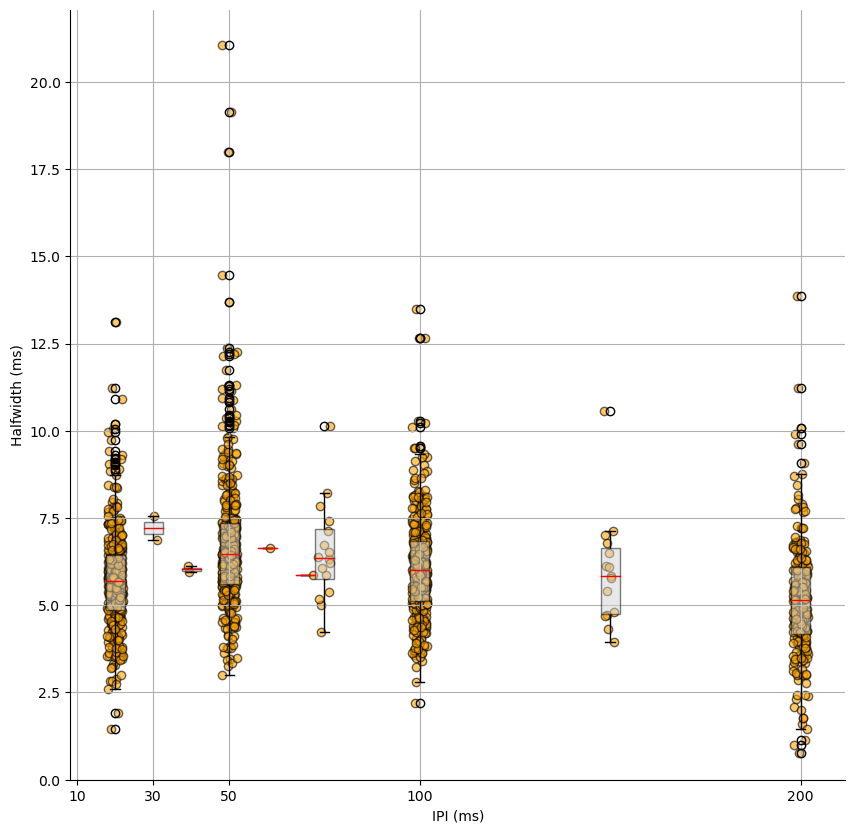

In [19]:
# jittered scatter of all Pulse 1 HW's 
plt.figure(figsize=(10, 10))
# average data grouped by Date, Slice, Location, Recording
grouped = ppr_df.groupby(['Date', 'Slice', 'Location', 'Recording', 'IPI']).mean().reset_index()
x_jitter = np.random.uniform(-2, 2, size=len(grouped))  # jitter for better visualization
plt.scatter(grouped['IPI'] + x_jitter, grouped['halfwidth'], alpha=0.6, color='orange', edgecolors='k')
plt.xlabel('IPI (ms)')
plt.ylabel('Halfwidth (ms)')    
plt.grid(True)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, None)
# boxplot overlay of grouped data
plt.boxplot([grouped[grouped['IPI'] == ipi]['halfwidth'].dropna() for ipi in sorted(grouped['IPI'].unique())],
            positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
            boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
            medianprops=dict(color='red'))
# set x ticks to unique IPI values
x_ticks = [10, 30, 50, 100, 200]
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.savefig(output_fig_dir + f'halfwidth_vs_ipi_first_pulse.png')
plt.show()

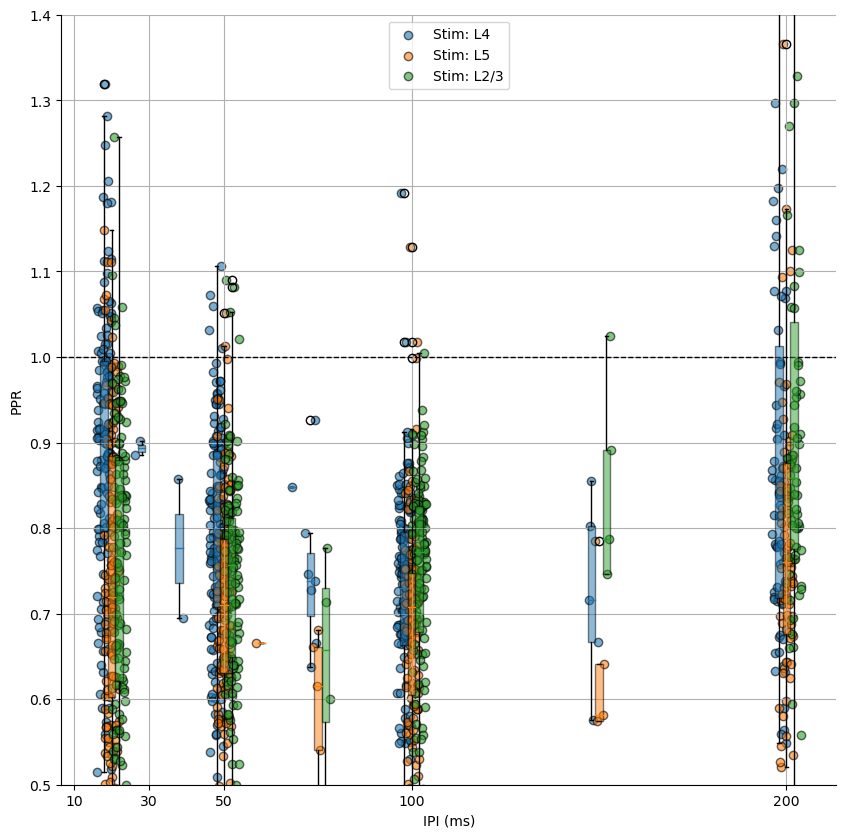

In [20]:
# now compare across Stim_Layer [L2/3, L4, L5]

plt.figure(figsize=(10, 10))
# average data grouped by Date, Slice, Location, Recording
grouped = ppr_df.groupby(['Date', 'Slice', 'Location', 'Recording', 'Stim_Layer']).mean().reset_index()
stim_colors = ['tab:blue', 'tab:orange', 'tab:green']
scatter_widths = 2
for i_l, layer in enumerate(grouped['Stim_Layer'].unique()):
    layer_df = grouped[grouped['Stim_Layer'] == layer]
    x_jitter = (np.random.rand(len(layer_df)) - 0.5) * 2  # jitter for better visualization
    plt.scatter(layer_df['IPI'] + x_jitter * 2 + (i_l-1) * scatter_widths, layer_df['PPR'], alpha=0.6, edgecolors='k', label=f'Stim: {layer}', color=stim_colors[i_l])

    # boxplot overlay of data for each layer
    plt.boxplot([layer_df[layer_df['IPI'] == ipi]['PPR'].dropna() for ipi in sorted(layer_df['IPI'].unique())],
            positions=np.array(sorted(layer_df['IPI'].unique())) + (i_l-1) * scatter_widths, widths=scatter_widths, patch_artist=True,
            boxprops=dict(facecolor=stim_colors[i_l], color='black', alpha=0.5),
            medianprops=dict(color=stim_colors[i_l]))

plt.xlabel('IPI (ms)')
plt.ylabel('PPR')
plt.grid(True)
plt.legend()
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set y limit to 0 to 2
plt.ylim(0, 4.5)
if exclude_10ms:
    plt.ylim(0.5, 1.4)

# draw horizontal lines at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# set x ticks to unique IPI values
x_ticks = [10, 30, 50, 100, 200]

plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.savefig(output_fig_dir + f'ppr_vs_ipi_by_stim_layer.png')
plt.show()

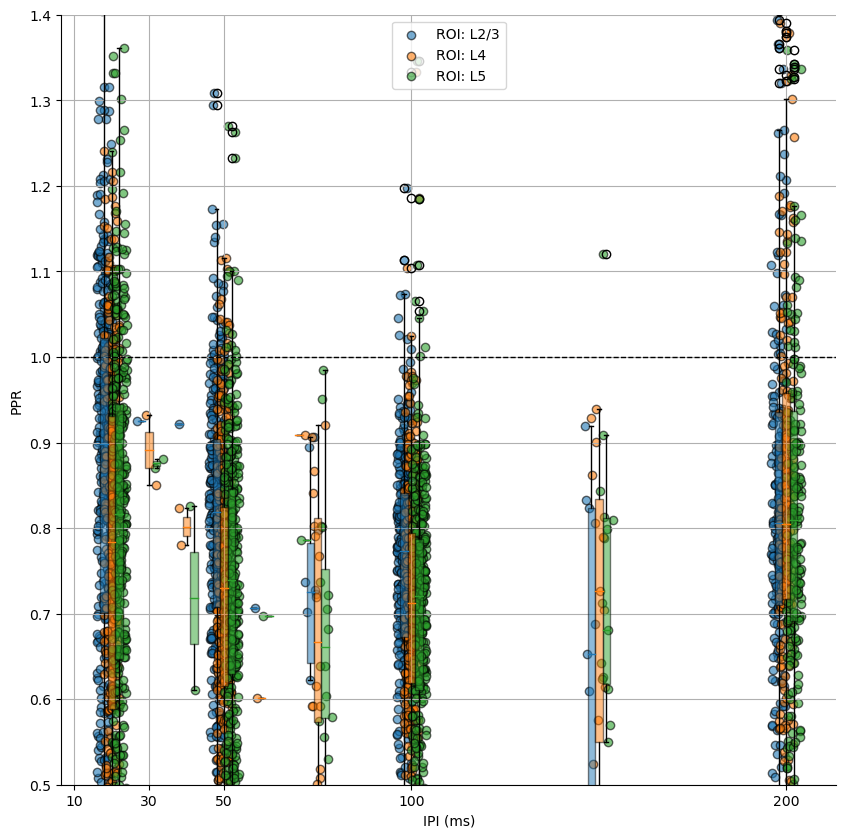

In [21]:
# now compare across ROI_Loc [L2/3, L4, L5]

plt.figure(figsize=(10, 10))
# average data grouped by Date, Slice, Location, Recording
grouped = ppr_df.groupby(['Date', 'Slice', 'Location', 'Recording', 'ROI_Loc']).mean().reset_index()
stim_colors = ['tab:blue', 'tab:orange', 'tab:green']
scatter_widths = 2
for i_l, layer in enumerate(grouped['ROI_Loc'].unique()):
    layer_df = grouped[grouped['ROI_Loc'] == layer]
    x_jitter = (np.random.rand(len(layer_df)) - 0.5) * 2  # jitter for better visualization
    plt.scatter(layer_df['IPI'] + x_jitter * 2 + (i_l-1) * scatter_widths, layer_df['PPR'], alpha=0.6, edgecolors='k', label=f'ROI: {layer}', color=stim_colors[i_l])

    # boxplot overlay of data for each layer
    plt.boxplot([layer_df[layer_df['IPI'] == ipi]['PPR'].dropna() for ipi in sorted(layer_df['IPI'].unique())],
            positions=np.array(sorted(layer_df['IPI'].unique())) + (i_l-1) * scatter_widths, widths=scatter_widths, patch_artist=True,
            boxprops=dict(facecolor=stim_colors[i_l], color='black', alpha=0.5),
            medianprops=dict(color=stim_colors[i_l]))

plt.xlabel('IPI (ms)')
plt.ylabel('PPR')
plt.grid(True)
plt.legend()
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set y limit to 0 to 2
plt.ylim(0, 4.5)
if exclude_10ms:
    plt.ylim(0.5, 1.4)

# draw horizontal lines at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# set x ticks to unique IPI values
x_ticks = [10, 30, 50, 100, 200]

plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.savefig(output_fig_dir + f'ppr_vs_ipi_by_roi_loc.png')
plt.show()

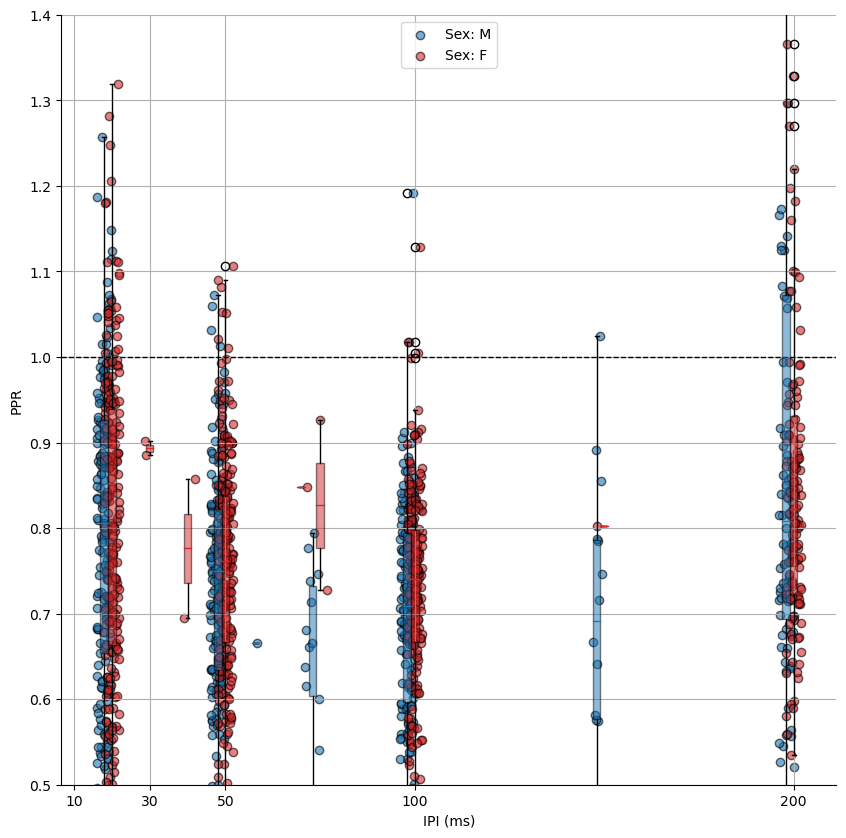

In [22]:
# now compare across Sex ("M" and "F")

plt.figure(figsize=(10, 10))
# average data grouped by Date, Slice, Location, Recording
grouped = ppr_df.groupby(['Date', 'Slice', 'Location', 'Recording', 'Sex']).mean().reset_index()
sex_colors = ['tab:blue', 'tab:red']
scatter_widths = 2
for i_l, sex in enumerate(grouped['Sex'].unique()):
    sex_df = grouped[grouped['Sex'] == sex]
    x_jitter = (np.random.rand(len(sex_df)) - 0.5) * 2  # jitter for better visualization
    plt.scatter(sex_df['IPI'] + x_jitter * 2 + (i_l-1) * scatter_widths, sex_df['PPR'], alpha=0.6, edgecolors='k', label=f'Sex: {sex}', color=sex_colors[i_l])

    # boxplot overlay of data for each layer
    plt.boxplot([sex_df[sex_df['IPI'] == ipi]['PPR'].dropna() for ipi in sorted(sex_df['IPI'].unique())],
            positions=np.array(sorted(sex_df['IPI'].unique())) + (i_l-1) * scatter_widths, widths=scatter_widths, patch_artist=True,
            boxprops=dict(facecolor=sex_colors[i_l], color='black', alpha=0.5),
            medianprops=dict(color=sex_colors[i_l]))

plt.xlabel('IPI (ms)')
plt.ylabel('PPR')
plt.grid(True)
plt.legend()
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set y limit to 0 to 2
plt.ylim(0, 4.5)
if exclude_10ms:
    plt.ylim(0.5, 1.4)

# draw horizontal lines at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# set x ticks to unique IPI values
x_ticks = [10, 30, 50, 100, 200]

plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.savefig(output_fig_dir + f'ppr_vs_ipi_by_sex.png')
plt.show()

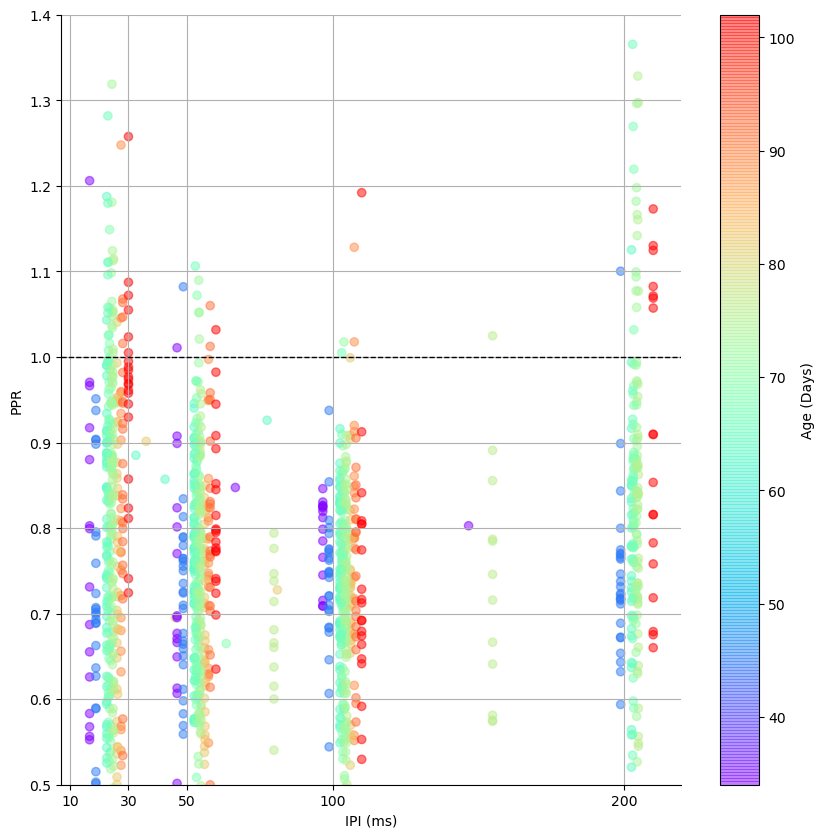

In [23]:
# now compare across Age (integer in Days)
# use a colorscale for age

plt.figure(figsize=(10, 10))
# average data grouped by Date, Slice, Location, Recording
age_col_width = 20
grouped = ppr_df.groupby(['Date', 'Slice', 'Location', 'Recording', 'Age']).mean().reset_index()

# x_loc is based on age so that older ages are shifted to the right, contained within the scatter width (age_col_width)
x_loc = grouped['Age'] / grouped['Age'].max() * age_col_width - (age_col_width / 2)
plt.scatter(grouped['IPI'] + x_loc, grouped['PPR'], c=grouped['Age'], cmap='rainbow', alpha=0.5)

plt.xlabel('IPI (ms)')
plt.ylabel('PPR')
plt.grid(True)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set y limit to 0 to 2
plt.ylim(0, 4.5)
if exclude_10ms:
    plt.ylim(0.5, 1.4)

# draw horizontal lines at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# show colorbar for age
cbar = plt.colorbar()
cbar.set_label('Age (Days)')

# colobar horizontal and on top
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')



# set x ticks to unique IPI values
x_ticks = [10, 30, 50, 100, 200]

plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.savefig(output_fig_dir + f'ppr_vs_ipi_by_age.png')
plt.show()

In [24]:
# add a column "Home_Neighbor" that is "Home" if ROI == 1 else "Neighbor"
ppr_df['Home_Neighbor'] = ppr_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')

# 3-way ANOVA tests for PPR across IPI, Stim_Loc, and ROI_Loc
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for hn in ['Home', 'Neighbor']:
    hn_df = ppr_df[ppr_df['Home_Neighbor'] == hn]

    # filter nan from hn_df
    hn_df = hn_df.dropna(subset=['PPR', 'IPI', 'Stim_Layer', 'ROI_Loc'])
    
    model = ols('PPR ~ C(IPI) + C(Stim_Layer) + C(ROI_Loc) + C(IPI):C(Stim_Layer) + C(IPI):C(ROI_Loc) + C(Stim_Layer):C(ROI_Loc)', data=hn_df).fit()
    anova_table = anova_lm(model, typ=2)
    print(f"ANOVA results for {hn}:")
    print(anova_table)
    
    # significant differences to further test
    sig_diffs = {
        'Home': ['IPI', 'Stim_Layer', 'ROI_Loc', 'Stim_Layer:ROI_Loc'],
        'Neighbor': ['Stim_Layer', 'IPI:Stim_Layer', 'IPI:ROI_Loc']
    }
    for s_diff in sig_diffs[hn]:
        print(f"Tukey's HSD test for {s_diff} in {hn}:")
        if ':' not in s_diff:
            # Tukey's HSD test for multiple comparisons
            
            tukey = pairwise_tukeyhsd(endog=hn_df['PPR'],
                                    groups=hn_df[s_diff], alpha=0.05)
            print(tukey)
        else:
            # double interaction terms require different handling
            # make a column that is the two columns appended
            cols = s_diff.split(':')
            hn_df[s_diff] = hn_df[cols[0]].astype(str) + "_" + hn_df[cols[1]].astype(str)
            # make nested groups for Tukey
            tukey = pairwise_tukeyhsd(endog=hn_df['PPR'],
                                      groups=hn_df[s_diff], alpha=0.05)
            print(tukey)

model = ols('PPR ~ C(IPI) + C(Stim_Layer) + C(ROI_Loc) + C(IPI):C(Stim_Layer) + C(IPI):C(ROI_Loc) + C(Stim_Layer):C(ROI_Loc)', data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
print("ANOVA results for both:")
print(anova_table)


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\727484968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppr_df['Home_Neighbor'] = ppr_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 5
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does no

ANOVA results for Home:
                              sum_sq      df          F        PR(>F)
C(IPI)                      4.432973     9.0   2.613774  2.288703e-02
C(Stim_Layer)               6.845239     2.0  18.162433  1.401390e-08
C(ROI_Loc)                  1.455244     2.0   3.861192  2.111873e-02
C(IPI):C(Stim_Layer)        7.025445    18.0   2.071175  1.065663e-02
C(IPI):C(ROI_Loc)           2.401631    18.0   0.708026  8.062363e-01
C(Stim_Layer):C(ROI_Loc)   10.694896     4.0  14.188353  1.667834e-11
Residual                  780.162227  4140.0        NaN           NaN
Tukey's HSD test for IPI in Home:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  20.0   30.0   0.1532    0.9 -0.4705  0.7769  False
  20.0   40.0   0.0674    0.9 -0.5563  0.6911  False
  20.0   50.0  -0.0688 0.0075 -0.1273 -0.0104   True
  20.0   60.0  -0.1589    0.9 -0.9634  0.6456  False
  20.0   70

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
100.0_L2/3   100.0_L4  -0.0628    0.9 -0.1998  0.0741  False
100.0_L2/3   100.0_L5  -0.0818 0.8517 -0.2194  0.0558  False
100.0_L2/3 150.0_L2/3   -0.065    0.9  -0.609  0.4789  False
100.0_L2/3   150.0_L4  -0.0789    0.9 -0.6548  0.4969  False
100.0_L2/3   150.0_L5   -0.166    0.9   -0.71  0.3779  False
100.0_L2/3  20.0_L2/3   0.0118    0.9 -0.1294   0.153  False
100.0_L2/3    20.0_L4   0.1027 0.4823 -0.0344  0.2397  False
100.0_L2/3    20.0_L5  -0.0159    0.9 -0.1534  0.1215  False
100.0_L2/3 200.0_L2/3   0.3208  0.001  0.1576   0.484   True
100.0_L2/3   200.0_L4   0.3012  0.001  0.1452  0.4571   True
100.0_L2/3   200.0_L5   0.1667 0.0273  0.0078  0.3256   True
100.0_L2/3    30.0_L4   0.0969    0.9 -0.6274  0.8212  False
100.0_L2/3    40.0_L4  -0.0091    0.9 -0.7334  0.7152  False
100.0_L2/3  50.0_L2/3  -

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 5
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


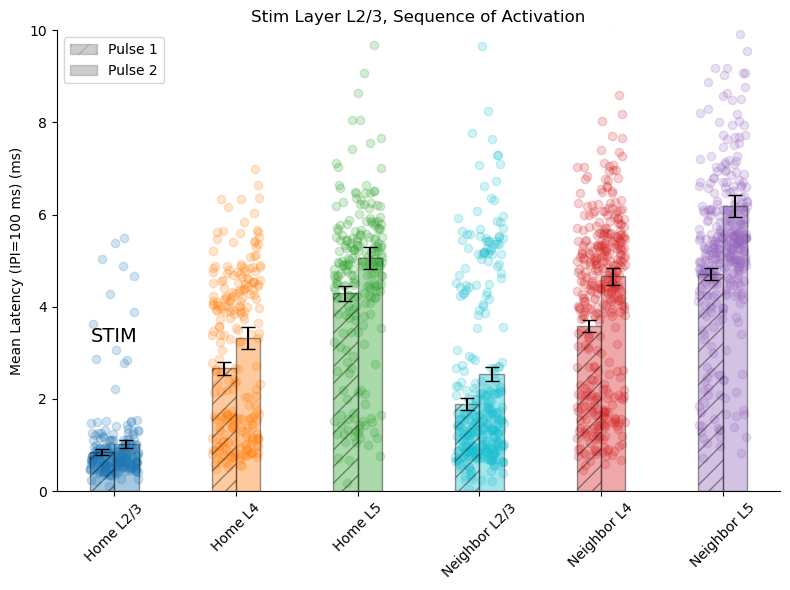

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


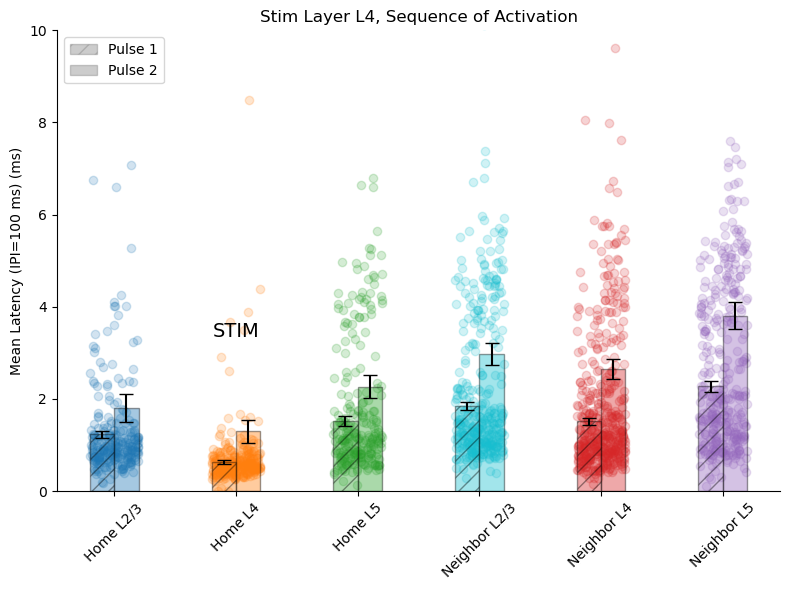

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


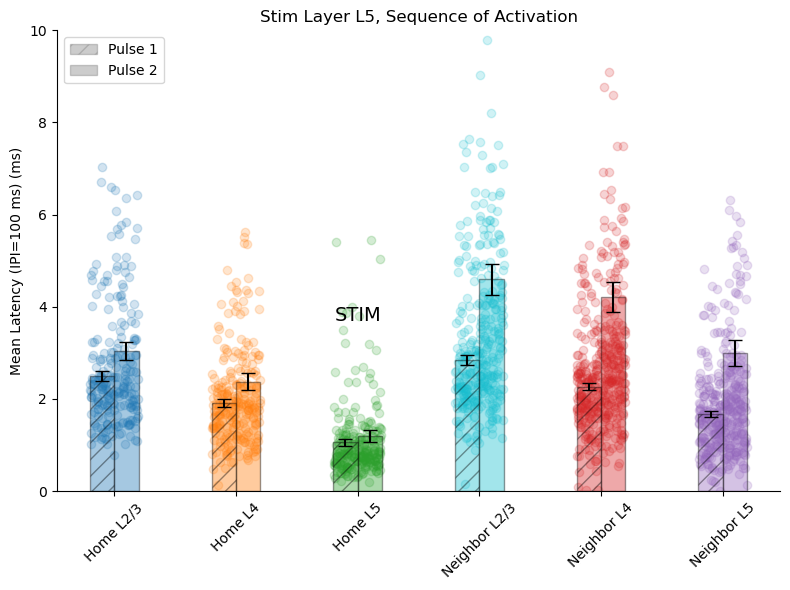

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


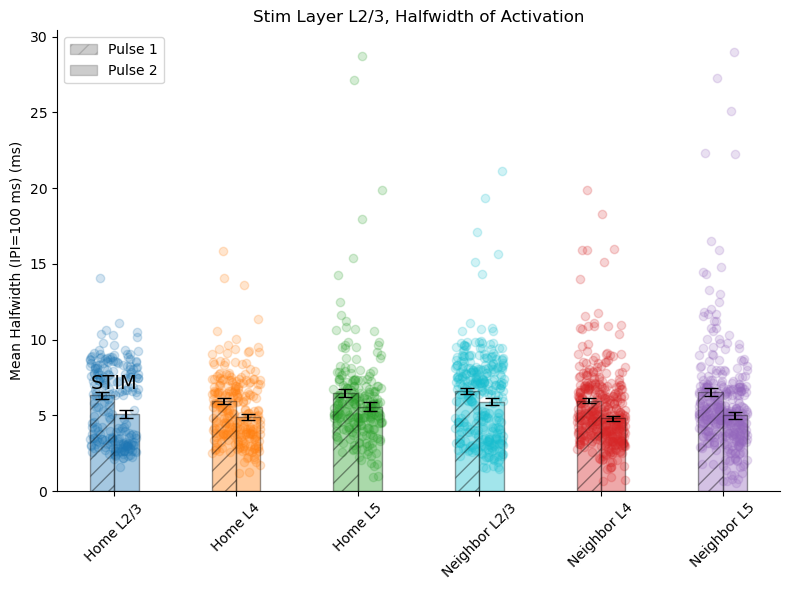

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


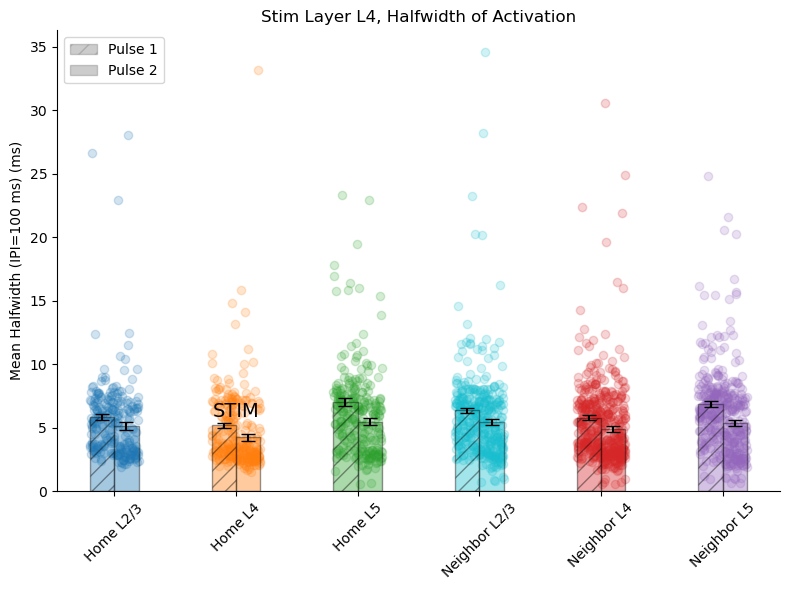

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


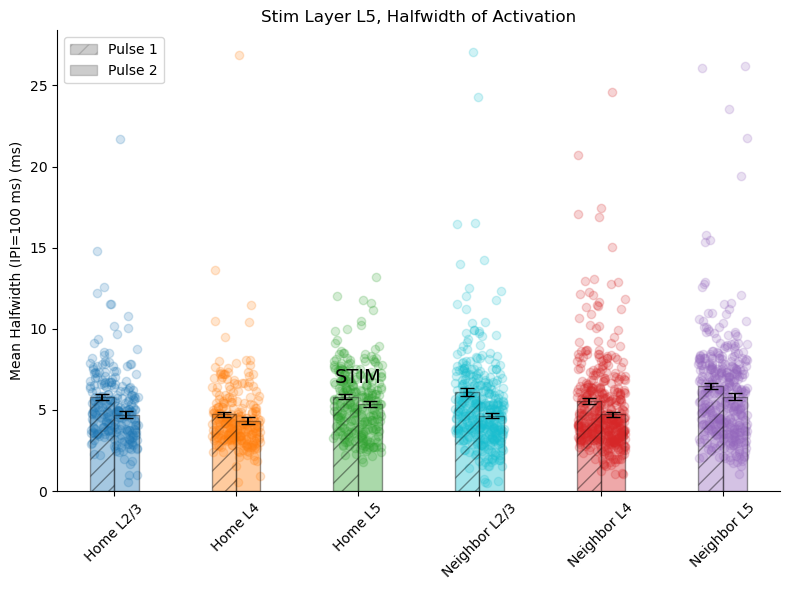

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


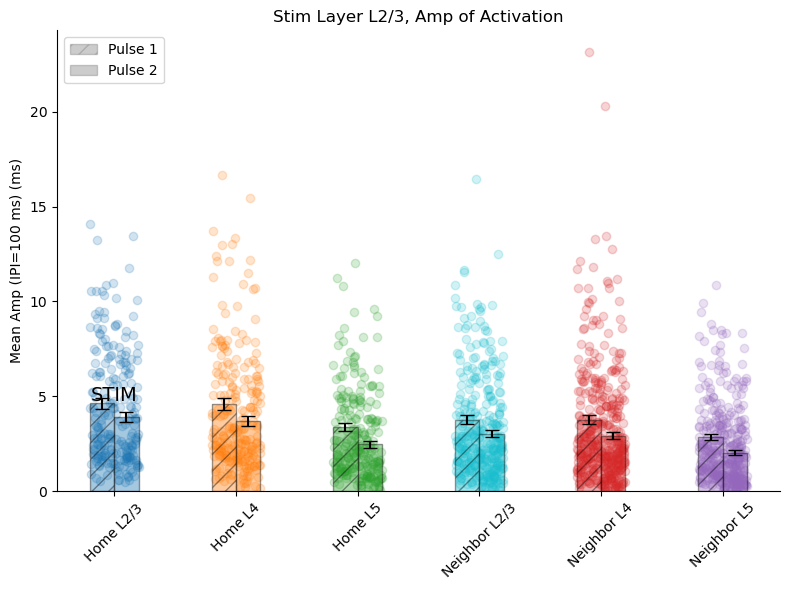

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


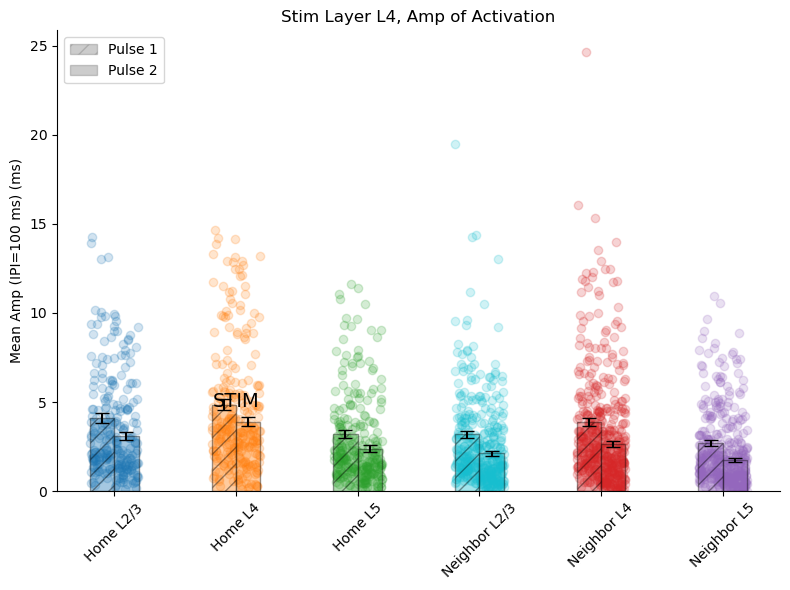

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_22340\3383671556.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]


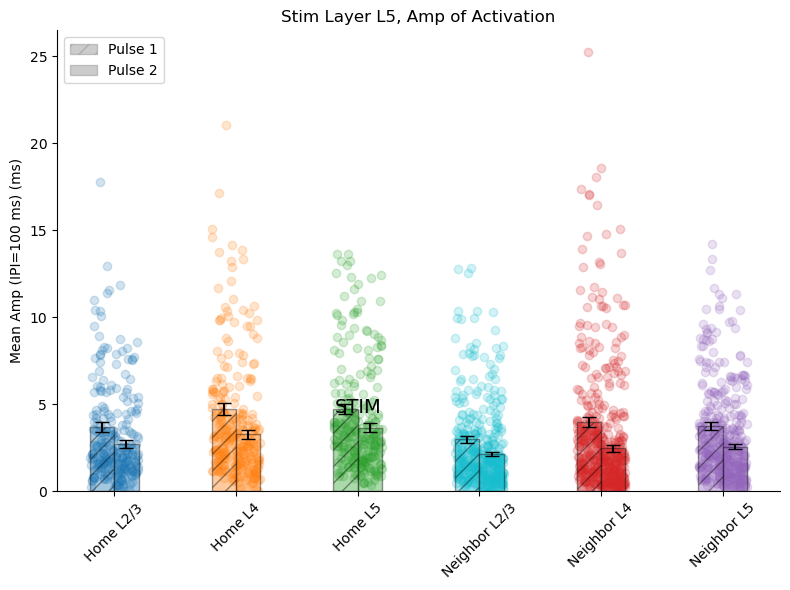

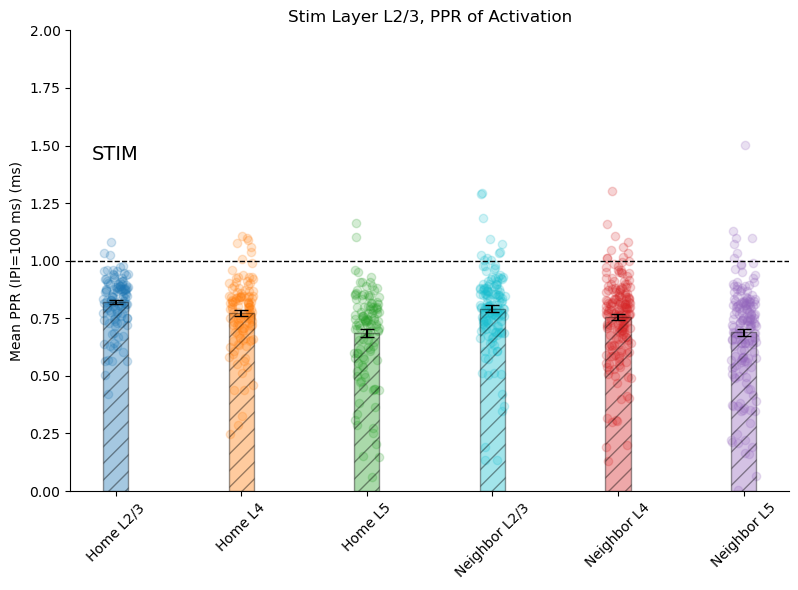

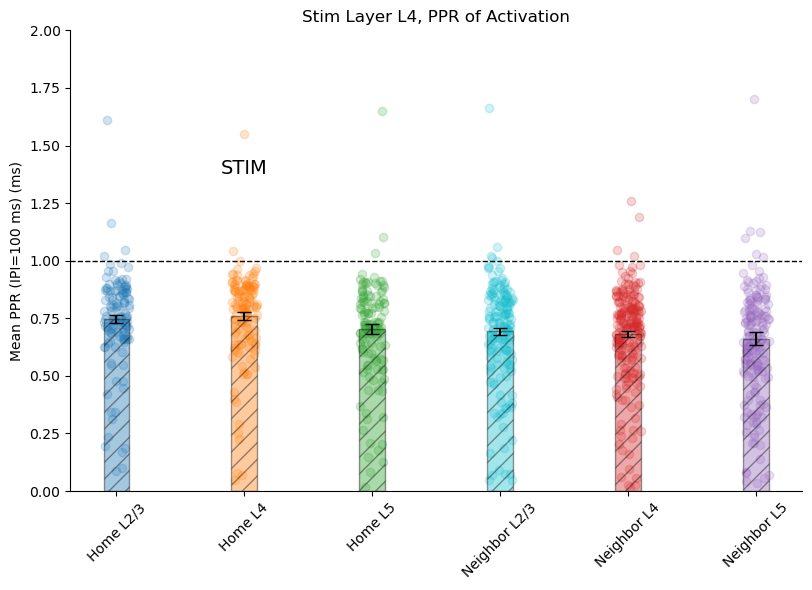

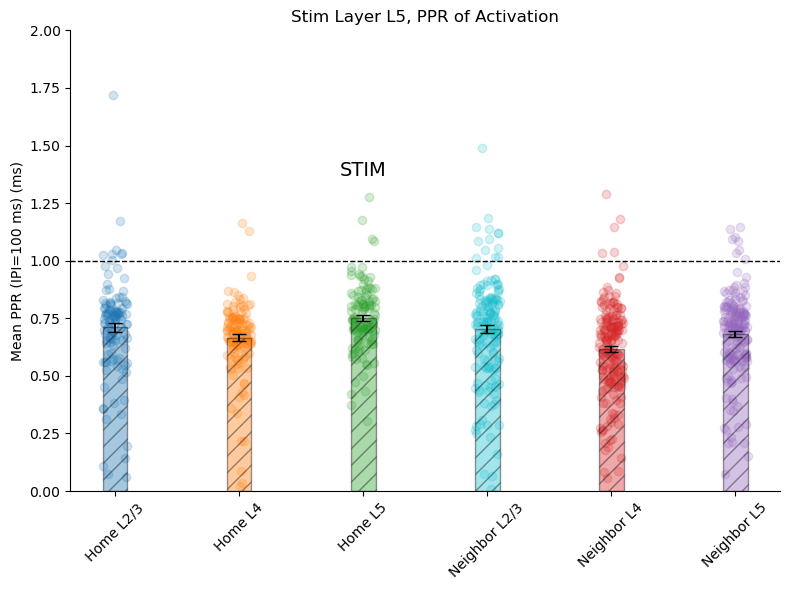

In [25]:
# barrel latency analysis visualization
# for each Stim_Layer, plot the mean latency for each HN_ROI_Loc 
for metric in ['latency:100', 'halfwidth:100', 'amp:100', 'PPR:100']:
    ipi = None
    if ':' in metric:
        ipi = int(metric.split(':')[1])
        metric = metric.split(':')[0]
    for i_stim, stim_layer in enumerate(['L2/3', 'L4', 'L5']):
        plt.figure(figsize=(8, 6))
        for i_pulse, pulse_df in enumerate([ppr_df, ppr_df_pulse_2]):

            if metric == 'PPR' and i_pulse == 1:
                continue  # PPR only for pulse 1
            
            hn_roi_means = {}
            hn_roi_sems = {}
            sub_dfs = []
            for hn in ['Home', 'Neighbor']:
                for roi_loc in ['L2/3', 'L4', 'L5']:
                    sub_df = pulse_df[(pulse_df['Stim_Layer'] == stim_layer) &
                                    (pulse_df['Home_Neighbor'] == hn) &
                                    (pulse_df['ROI_Loc'] == roi_loc)]
                    if ipi is not None:
                        sub_df = sub_df[sub_df['IPI'] == ipi]
                    
                    sub_df = sub_df[sub_df[metric] > 0]
                    mean_latency = sub_df[metric].mean()
                    sem_latency = sub_df[metric].sem()
                    hn_roi_means[f"{hn}_{roi_loc}"] = mean_latency
                    hn_roi_sems[f"{hn}_{roi_loc}"] = sem_latency
                    sub_dfs.append(sub_df)

            labels = list(hn_roi_means.keys())
            means = [hn_roi_means[label] for label in labels]
            sems = [hn_roi_sems[label] for label in labels]

            x = np.arange(len(labels)) + (i_pulse * 0.2) # offset for pulse 1 and pulse 2
            colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:red', 'tab:purple']
            for i in range(len(colors)):
                x_pos = x[i]
                label = labels[i]
                sub_df = sub_dfs[i]
                x_jitter = (np.random.rand(len(sub_df)) - 0.5) * 0.2  # jitter for better visualization
                plt.scatter(np.full(len(sub_df), x_pos) + x_jitter, sub_df[metric], alpha=0.2, color=colors[i])

            # hatched bars for pulse 1, filled bars for pulse 2
            hatched = (i_pulse == 0)
            plt.bar(x, means, yerr=sems, capsize=5, 
                    color=colors, alpha=0.4, width=0.2, 
                    hatch='//' if hatched else '', edgecolor='black', label=f'Pulse {i_pulse + 1}')
            plt.xticks(x - (0.1 * (metric != 'PPR')) , [lbl.replace("_", " ") for lbl in labels], rotation=45)
            
        # place a star above the stimulated bar pair
        x_stim = x[i_stim] - (0.1 * (metric != 'PPR'))  # center above the stim layer bars
        y_max = max([hn_roi_means[f"Home_{stim_layer}"], hn_roi_means[f"Neighbor_{stim_layer}"]]) + 0.5
        plt.text(x_stim, y_max + 0.1, 'STIM', ha='center', va='bottom', color='black', fontsize=14)

        metric_label = (metric.capitalize() if metric != 'PPR' else 'PPR') + f' (IPI={ipi} ms)'
        plt.ylabel(f'Mean {metric_label} (ms)')
        plt.title(f'Stim Layer {stim_layer}, {("Sequence" if metric == "latency" else "PPR" if metric == "PPR" else metric.capitalize())} of Activation')
        plt.tight_layout()
        # remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        
        
        if metric == 'latency':
            plt.ylim(0, 10)
        if metric == 'halfwidth':
            plt.ylim(0, None)
        if metric == 'amp':
            plt.ylim(0, None)
        if metric == 'PPR':
            plt.ylim(0, 2)

        if metric == 'PPR':
            # mark y=1 line
            plt.axhline(y=1, color='black', linestyle='--', linewidth=1)
        else:
            # legend for pulse 1 and pulse 2 
            handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, hatch='//', edgecolor='black'),
                    plt.Rectangle((0,0),1,1, color='gray', alpha=0.4, edgecolor='black')]
            labels = ['Pulse 1', 'Pulse 2']
            plt.legend(handles, labels, loc='upper left')
        plt.savefig(output_fig_dir + f'mean_{metric}_stim_{stim_layer.replace("/", "_")}_pulses_bar.png')
        plt.show()

No handles with labels found to put in legend.


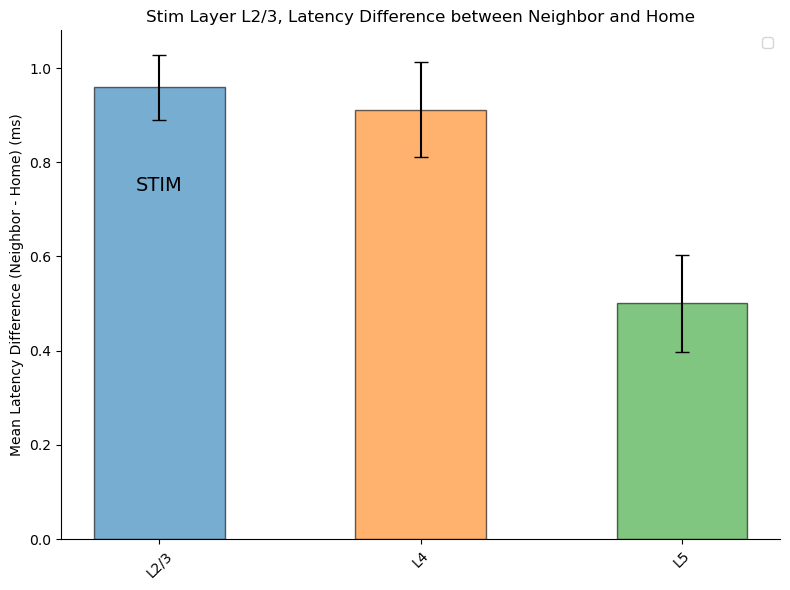

No handles with labels found to put in legend.


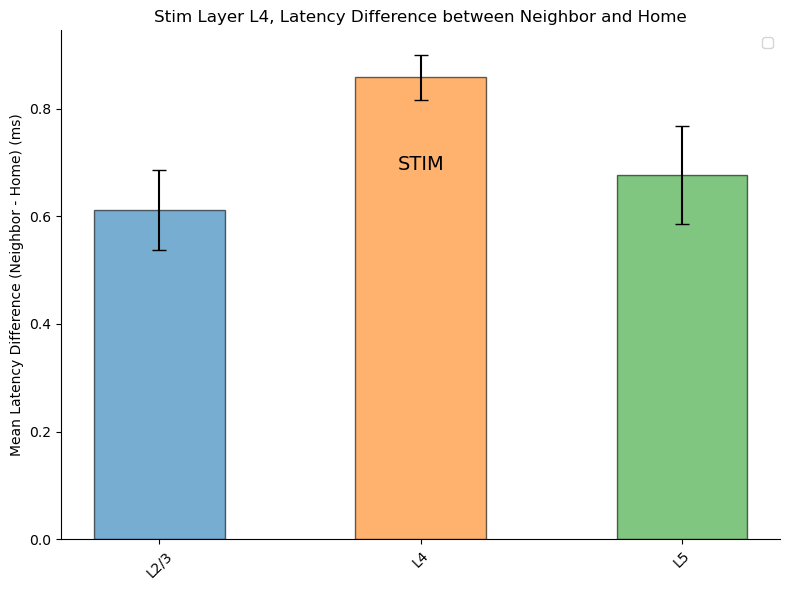

No handles with labels found to put in legend.


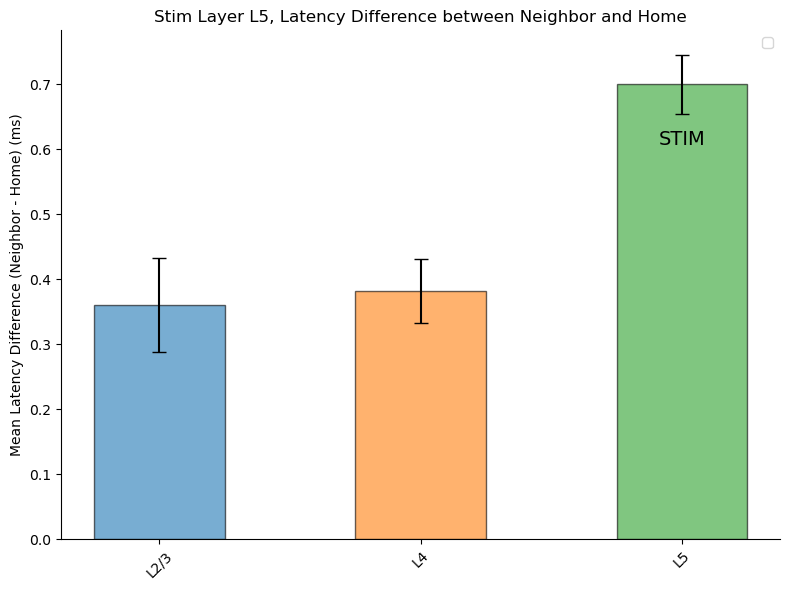

In [26]:
# plot (neighbor latency minus home latency) for each ROI_Loc and Stim_Layer
for metric in ['latency']:
    for i_stim, stim_layer in enumerate(['L2/3', 'L4', 'L5']):

        plt.figure(figsize=(8, 6))
        hn_roi_diffs = {}
        sub_dfs = []
        for roi_loc in ['L2/3', 'L4', 'L5']:
            home_df = ppr_df[(ppr_df['Stim_Layer'] == stim_layer) &
                            (ppr_df['Home_Neighbor'] == 'Home') &
                            (ppr_df['ROI_Loc'] == roi_loc)]
            neighbor_df = ppr_df[(ppr_df['Stim_Layer'] == stim_layer) &
                                (ppr_df['Home_Neighbor'] == 'Neighbor') &
                                (ppr_df['ROI_Loc'] == roi_loc)]
            home_df = home_df[home_df[metric] > 0]
            neighbor_df = neighbor_df[neighbor_df[metric] > 0]
            mean_home = home_df[metric].mean()
            mean_neighbor = neighbor_df[metric].mean()
            diff = mean_neighbor - mean_home
            hn_roi_diffs[f"{roi_loc}"] = diff
            sub_dfs.append((home_df, neighbor_df))

        labels = list(hn_roi_diffs.keys())
        diffs = [hn_roi_diffs[label] for label in labels]

        x = np.arange(len(labels))
        colors = ['tab:blue', 'tab:orange', 'tab:green']

        # mark STIM in the stimulated ROI location
        x_stim = x[i_stim]
        y_max = max(diffs) + 0.5
        plt.text(x_stim, y_max/2, 'STIM', ha='center', va='bottom', color='black', fontsize=14)
        
        # with error bars showing SEM of the difference
        sems = []
        for i in range(len(labels)):
            home_df, neighbor_df = sub_dfs[i]
            # calculate SEM of the difference using sqrt(SEM_home^2 + SEM_neighbor^2)
            sem_home = home_df[metric].sem()
            sem_neighbor = neighbor_df[metric].sem()
            sem_diff = np.sqrt(sem_home**2 + sem_neighbor**2)
            sems.append(sem_diff)
        plt.bar(x, diffs, yerr=sems, capsize=5, 
                color=colors, alpha=0.6, width=0.5, 
                edgecolor='black')
        plt.xticks(x, labels, rotation=45)
        plt.ylabel(f'Mean {metric.capitalize()} Difference (Neighbor - Home) (ms)')
        plt.title(f'Stim Layer {stim_layer}, {metric.capitalize()} Difference between Neighbor and Home')
        plt.tight_layout()
        # remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.legend()
        plt.savefig(output_fig_dir + f'{metric}_difference_stim_{stim_layer.replace("/", "_")}_neighbor_minus_home.png')
        plt.show()



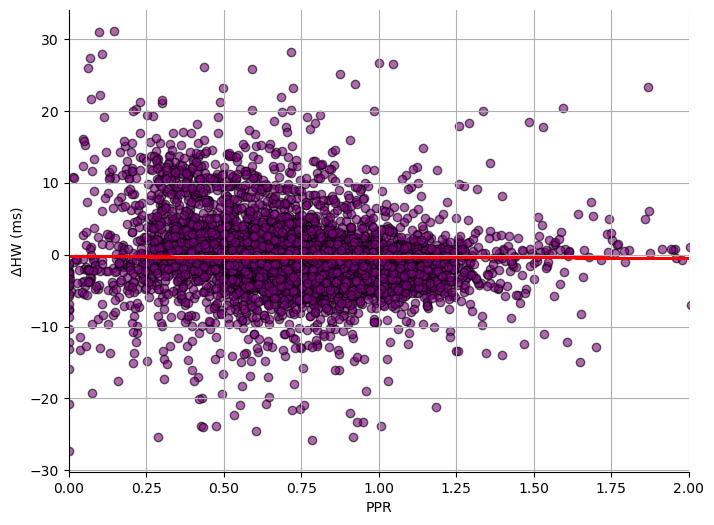

In [27]:
# do PPR and PPHW correlate? Scatter plot with regression line
plt.figure(figsize=(8, 6))
plt.scatter(ppr_df['PPR'], ppr_df['PPHW'], alpha=0.6, color='purple', edgecolors='k')
plt.xlabel('PPR')
plt.ylabel('ΔHW (ms)')
plt.grid(True)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# fit regression line
ppr_df_no_na = ppr_df.dropna(subset=['PPR', 'PPHW'])
m, b = np.polyfit(ppr_df_no_na['PPR'], ppr_df_no_na['PPHW'], 1)
plt.plot(ppr_df_no_na['PPR'], m * ppr_df_no_na['PPR'] + b, color='red')
plt.xlim(0, 2)
plt.savefig(output_fig_dir + f'pphw_vs_ppr.png')
plt.show()

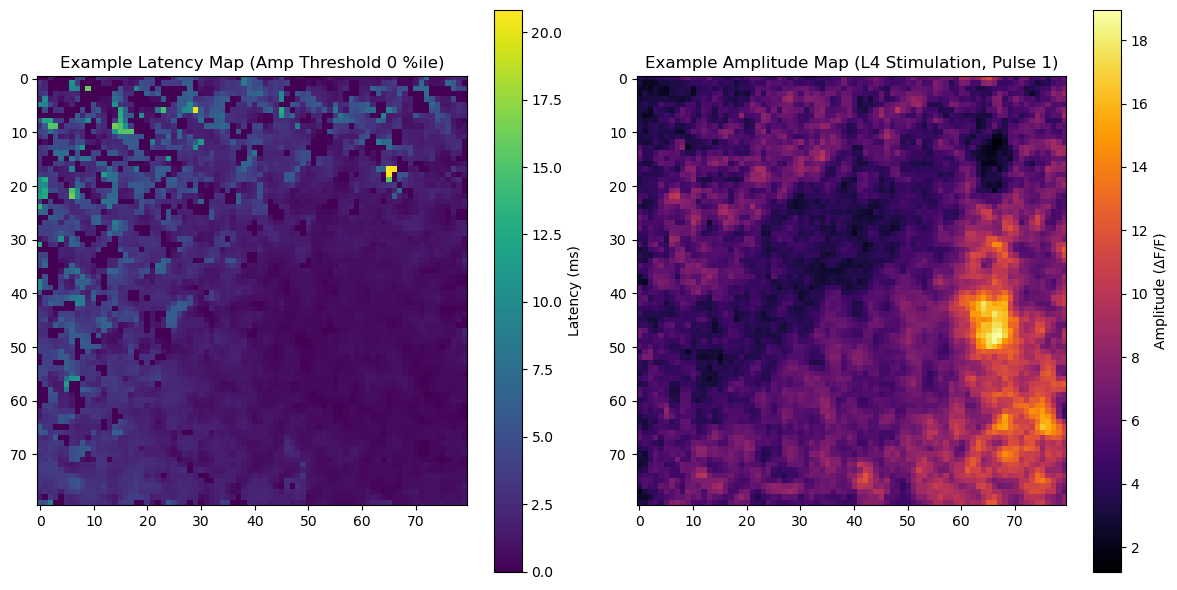

Number of initial candidate ROIs in example latency map: 7
Number of ROIs after size filter: 6
Number of ROIs after composite cluster label consistency filter: 4


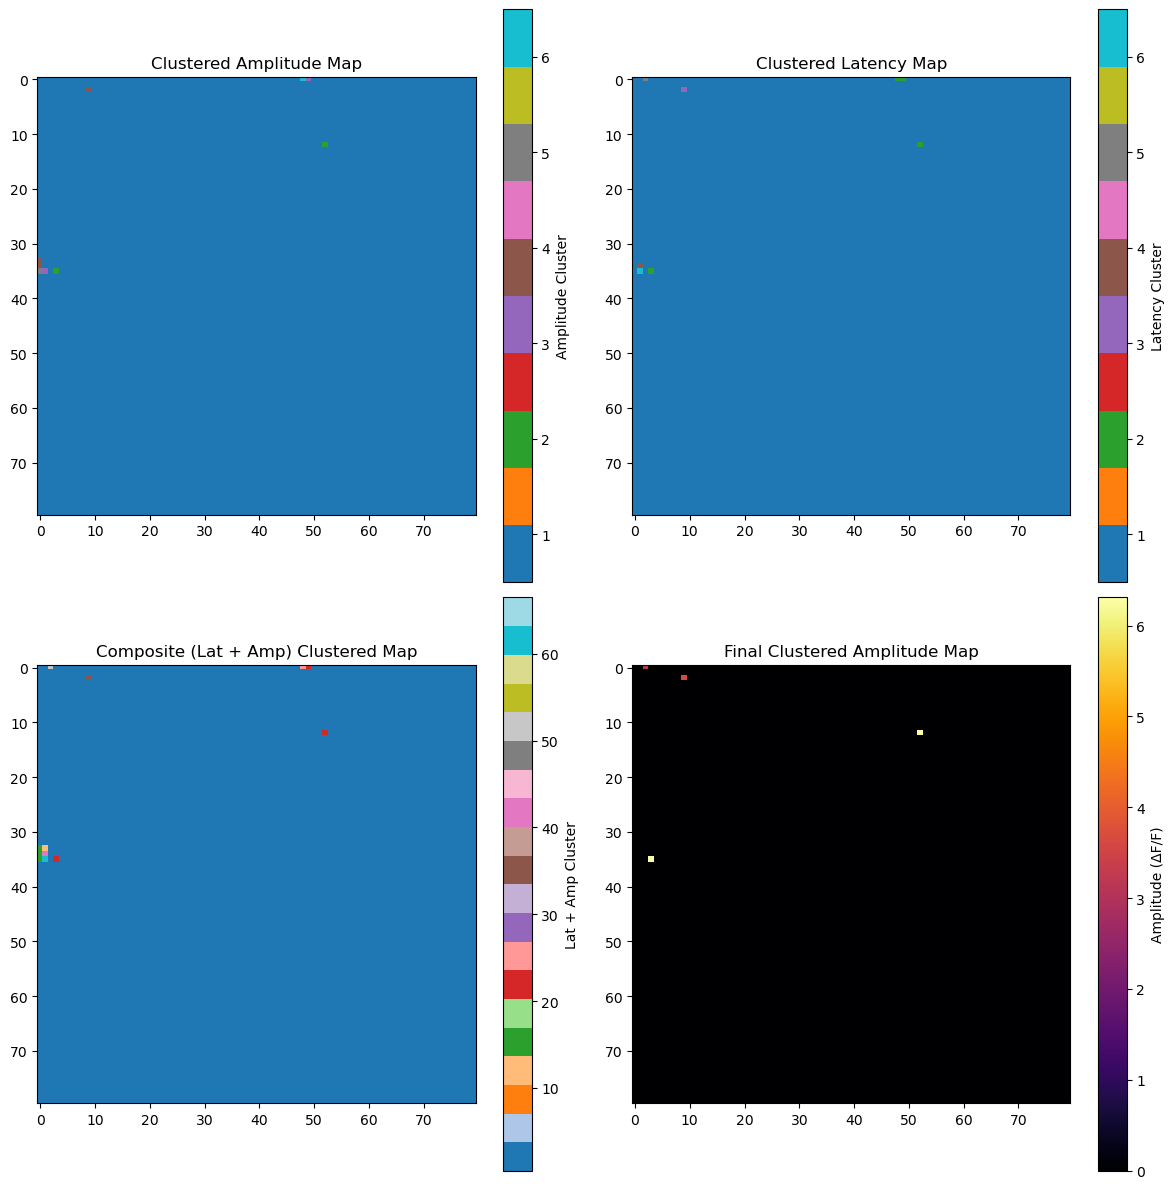

Number of ROIs after latency cluster filter: 5
Number of ROIs after amplitude cluster filter: 4


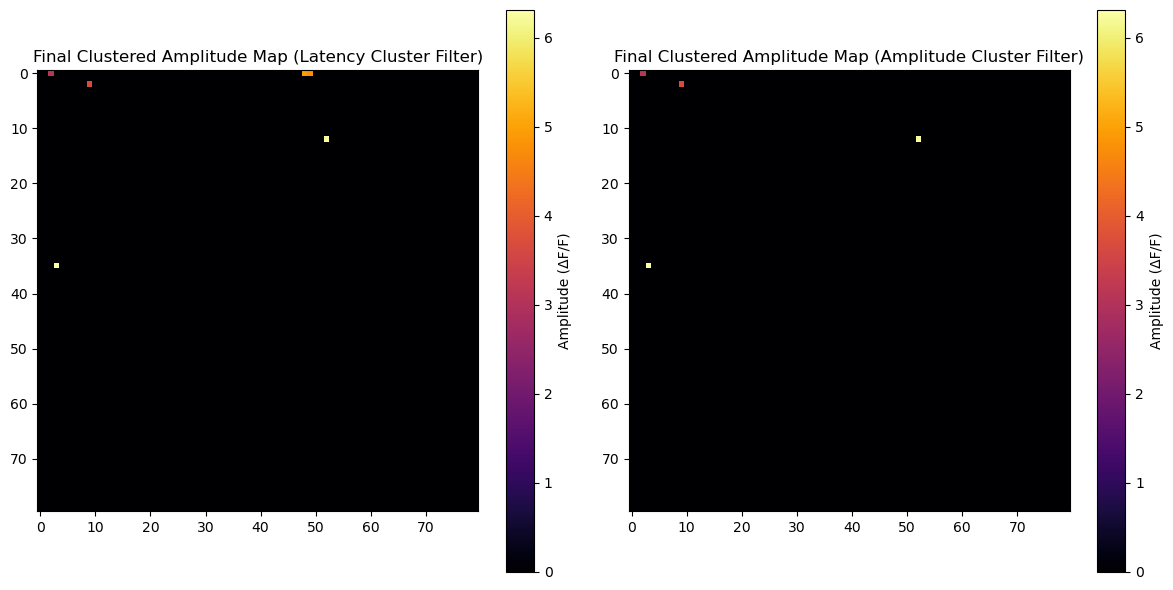

In [31]:
# latency map  example
example_data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_PVCre/'
example_lat_map_file = example_data_dir + '2022-09-16/_01_01_02_latency_array_analysis01_01_02_rois_layer_L4_pulse1.dat'
example_amp_map_file = example_data_dir + '2022-09-16/_01_01_02_amp_array_analysis01_01_02_rois_layer_L4_pulse1.dat'
example_stim_time = 49.250165289256195
lat_map = read_array_file(example_lat_map_file) - example_stim_time
amp_map = read_array_file(example_amp_map_file)
k_means_num_clusters = 3
xth_percentile = 0
# mask out latencies where amp_map is less than its xth percentile
amp_threshold = np.percentile(amp_map[amp_map > 0], xth_percentile)
lat_map_masked = np.where(amp_map >= amp_threshold, lat_map, 0)

# mCherry example 2/20/24, 02_01_01
use_mCherry_example = True
if use_mCherry_example:
    example_data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/mCherry-PV/'
    example_lat_map_file = example_data_dir + '02-20-24/zda/_02_01_01_latency_array_.dat'
    example_amp_map_file = example_data_dir + '02-20-24/zda/_02_01_01_amp_array_.dat'
    example_stim_time = 49.250165289256195
    lat_map = read_array_file(example_lat_map_file) - example_stim_time
    amp_map = read_array_file(example_amp_map_file)
    amp_threshold = np.percentile(amp_map[amp_map > 0], xth_percentile)
    lat_map_masked = np.where(amp_map >= amp_threshold, lat_map, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
plt.colorbar(label='Latency (ms)')
plt.title(f'Example Latency Map (Amp Threshold {xth_percentile} %ile)')
plt.subplot(1, 2, 2)
plt.imshow(amp_map, cmap='inferno')
plt.colorbar(label='Amplitude (ΔF/F)')
plt.title('Example Amplitude Map (L4 Stimulation, Pulse 1)')
plt.tight_layout()
plt.savefig(output_fig_dir + 'example_latency_amplitude_map.png')
plt.show()

def convert_mask_to_rois(mask):
    # convert a 2D mask array to a list of ROIs with their x,y coordinates
    # an ROI is a block of contiguous non-zero pixels
    
    rois = []
    visited_px_map = np.zeros_like(mask, dtype=bool)
    num_nonzero_px = np.sum(mask > 0)
    num_visited_px = 0
    while num_visited_px < num_nonzero_px:
        new_roi = []
        # find first unvisited non-zero pixel
        for y in range(mask.shape[0]):
            for x in range(mask.shape[1]):
                if mask[y, x] > 0 and not visited_px_map[y, x]:
                    new_roi.append((x, y))
                    visited_px_map[y, x] = True
                    num_visited_px += 1
                    break
            if len(new_roi) > 0:
                break
        # do a flood fill to find all contiguous non-zero pixels
        roi_index = 0
        while roi_index < len(new_roi):
            px_x, px_y = new_roi[roi_index]
            # check neighbors (up, down, left, right)
            neighbors = [(px_x-1, px_y), (px_x+1, px_y), (px_x, px_y-1), (px_x, px_y+1)]
            for n_x, n_y in neighbors:
                if (0 <= n_x < mask.shape[1]) and (0 <= n_y < mask.shape[0]):
                    if mask[n_y, n_x] > 0 and not visited_px_map[n_y, n_x]:
                        new_roi.append((n_x, n_y))
                        visited_px_map[n_y, n_x] = True
                        num_visited_px += 1
            roi_index += 1

        rois.append(new_roi)

    return rois

def convert_rois_to_mask(rois, shape):
    # convert a list of ROIs with their x,y coordinates to a 2D mask array
    mask = np.zeros(shape, dtype=int)
    for roi_index, roi in enumerate(rois):
        for px_x, px_y in roi:
            mask[px_y, px_x] = roi_index + 1  # ROI indices start at 1
    return mask

# roi must fit into a square of size max_roi_width x max_roi_width
max_roi_width = 6
roi_list = convert_mask_to_rois(lat_map_masked)
filtered_roi_list = []
for roi in roi_list:
    xs = [px[0] for px in roi]
    ys = [px[1] for px in roi]
    if (max(xs) - min(xs) + 1) <= max_roi_width and (max(ys) - min(ys) + 1) <= max_roi_width:
        filtered_roi_list.append(roi)

print(f"Number of initial candidate ROIs in example latency map: {len(roi_list)}")
print(f"Number of ROIs after size filter: {len(filtered_roi_list)}")

mask_2 = convert_rois_to_mask(filtered_roi_list, lat_map_masked.shape)
latencies_1D = lat_map[mask_2 > 0].flatten()
amps_1D = amp_map[mask_2 > 0].flatten()

# cluster latencies into 6 clusters using kmeans
from sklearn.cluster import KMeans
kmeans_lat = KMeans(n_clusters=6, random_state=0).fit(latencies_1D.reshape(-1, 1))
labels_lat = kmeans_lat.labels_
# create a new latency map with clustered latencies
lat_map_clustered = np.zeros_like(lat_map_masked)
lat_map_clustered[mask_2 > 0] = labels_lat + 1  # cluster labels start at 0, so add 1 for visualization

# cluster amps into 6 clusters using kmeans
kmeans_amp = KMeans(n_clusters=6, random_state=0).fit(amps_1D.reshape(-1, 1))
labels_amp = kmeans_amp.labels_
# create a new amplitude map with clustered amplitudes
amp_map_clustered = np.zeros_like(amp_map)
amp_map_clustered[mask_2 > 0] = labels_amp + 1  # cluster labels start at 0, so add 1 for visualization

# composite cluster label = (latency cluster) * 10 + (amplitude cluster)
composite_map = lat_map_clustered * 10 + amp_map_clustered

# for filtered_roi_list, look at the composite cluster labels for each ROI
# if it's not the case that all pixels in the ROI have the same composite label, filter it out
final_roi_list = []
for roi in filtered_roi_list:
    roi_labels = set()
    for px_x, px_y in roi:
        roi_labels.add(composite_map[px_y, px_x])
    if len(roi_labels) == 1 and 0 not in roi_labels:
        final_roi_list.append(roi)

print(f"Number of ROIs after composite cluster label consistency filter: {len(final_roi_list)}")

final_mask = convert_rois_to_mask(final_roi_list, lat_map_masked.shape)
final_amp_map_clustered = np.zeros_like(amp_map)
final_amp_map_clustered[final_mask > 0] = amp_map[final_mask > 0]
final_lat_map_clustered = np.zeros_like(lat_map_masked)
final_lat_map_clustered[final_mask > 0] = lat_map_masked[final_mask > 0]

# plot clustered latency and amplitude maps
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(amp_map_clustered, cmap='tab10', vmin=0.5, vmax=6.5)
plt.colorbar(label='Amplitude Cluster')
plt.title('Clustered Amplitude Map')
plt.subplot(2, 2, 2)
plt.imshow(lat_map_clustered, cmap='tab10', vmin=0.5, vmax=6.5)
plt.colorbar(label='Latency Cluster')
plt.title('Clustered Latency Map')
plt.subplot(2, 2, 3)
plt.imshow(composite_map, cmap='tab20', vmin=0.5, vmax=66.5)
plt.colorbar(label='Lat + Amp Cluster')
plt.title('Composite (Lat + Amp) Clustered Map')
plt.subplot(2, 2, 4)
plt.imshow(final_amp_map_clustered, cmap='inferno')
plt.colorbar(label='Amplitude (ΔF/F)')
plt.title('Final Clustered Amplitude Map')
plt.tight_layout()
plt.savefig(output_fig_dir + f'clustered_latency_and_amplitude_map_{k_means_num_clusters}.png')
plt.show()

# alterative final list: filter by latency cluster only, not composite
final_roi_list_2 = []
for roi in filtered_roi_list:
    roi_labels = set()
    for px_x, px_y in roi:
        roi_labels.add(lat_map_clustered[px_y, px_x])
    if len(roi_labels) == 1 and 0 not in roi_labels:
        final_roi_list_2.append(roi)

# alternative final list: filter by amplitude cluster only, not composite
final_roi_list_3 = []
for roi in filtered_roi_list:
    roi_labels = set()
    for px_x, px_y in roi:
        roi_labels.add(amp_map_clustered[px_y, px_x])
    if len(roi_labels) == 1 and 0 not in roi_labels:
        final_roi_list_3.append(roi)

print(f"Number of ROIs after latency cluster filter: {len(final_roi_list_2)}")
print(f"Number of ROIs after amplitude cluster filter: {len(final_roi_list_3)}")

# plot clustered latency and amplitude maps for final_roi_list_2
final_mask_2 = convert_rois_to_mask(final_roi_list_2, lat_map_masked.shape)
final_amp_map_clustered_2 = np.zeros_like(amp_map)
final_amp_map_clustered_2[final_mask_2 > 0] = amp_map[final_mask_2 > 0]
final_mask_3 = convert_rois_to_mask(final_roi_list_3, lat_map_masked.shape)
final_amp_map_clustered_3 = np.zeros_like(amp_map)
final_amp_map_clustered_3[final_mask_3 > 0] = amp_map[final_mask_3 > 0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(final_amp_map_clustered_2, cmap='inferno')
plt.colorbar(label='Amplitude (ΔF/F)')
plt.title('Final Clustered Amplitude Map (Latency Cluster Filter)')
plt.subplot(1, 2, 2)
plt.imshow(final_amp_map_clustered_3, cmap='inferno')
plt.colorbar(label='Amplitude (ΔF/F)')
plt.title('Final Clustered Amplitude Map (Amplitude Cluster Filter)')
plt.tight_layout()
plt.savefig(output_fig_dir + f'final_clustered_amplitude_maps_alternatives_{k_means_num_clusters}.png')
plt.show()

# get traces for the final_roi_list
example_zda_file = data_dir + '2022-09-16/01_01_02.zda'


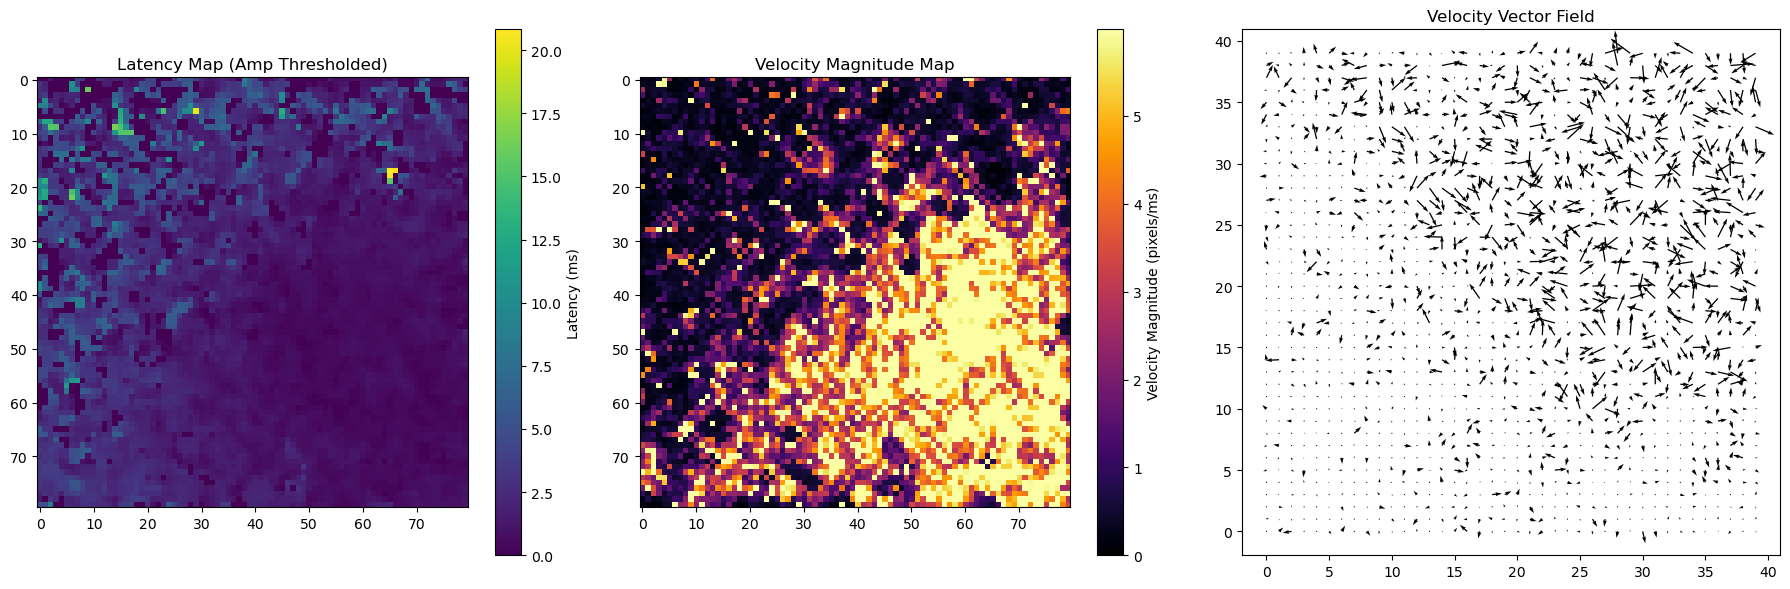

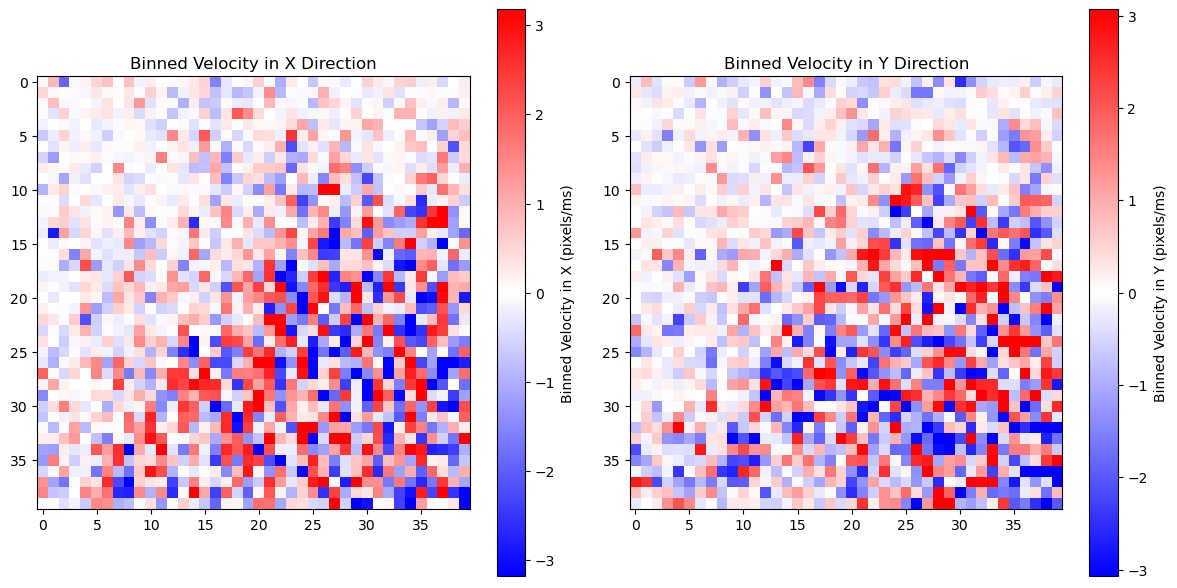

In [32]:
# generalized velocity vector analysis
# from lat_map, thresholded at amp_map's xth percentile
xth_percentile = 0
bin_size = 1

def compute_velocity_maps(lat_map, amp_map, xth_percentile=0, bin_size=1):
    # bin amp_map and lat_map
    amp_map_binned = amp_map.reshape(amp_map.shape[0]//bin_size, bin_size, amp_map.shape[1]//bin_size, bin_size).mean(axis=(1,3))
    lat_map_binned = lat_map.reshape(lat_map.shape[0]//bin_size, bin_size, lat_map.shape[1]//bin_size, bin_size).mean(axis=(1,3))
    amp_threshold = np.percentile(amp_map_binned[amp_map_binned > 0], xth_percentile)
    lat_map_masked = np.where(amp_map_binned >= amp_threshold, lat_map_binned, 0)

    # compute gradients
    gy, gx = np.gradient(lat_map_masked)

    # compute velocity vectors
    magnitude = np.sqrt(gx**2 + gy**2)

    # epsilon floor: to reduce extreme velocity values due to very small gradient magnitudes (striping)
    eps = np.percentile(magnitude, 20)  # a fixed value in ms/pixel
    safe_mag = np.maximum(magnitude, eps)
    velocity_magnitude = 1/ safe_mag
    velocity_x = -gx / safe_mag ** 2
    velocity_y = -gy / safe_mag ** 2

    # make quiver plot from 2x2 binned maps
    bin_size = 2
    binned_velocity_x = velocity_x.reshape(velocity_x.shape[0]//bin_size, bin_size, velocity_x.shape[1]//bin_size, bin_size).mean(axis=(1,3))
    binned_velocity_y = velocity_y.reshape(velocity_y.shape[0]//bin_size, bin_size, velocity_y.shape[1]//bin_size, bin_size).mean(axis=(1,3))
    return lat_map_masked, velocity_magnitude, binned_velocity_x, binned_velocity_y

lat_map_masked, velocity_magnitude, binned_velocity_x, binned_velocity_y = \
    compute_velocity_maps(lat_map, amp_map, xth_percentile=xth_percentile, bin_size=bin_size)

# plot velocity vector field, quiver plot
# also plot gy heatmap and gx heatmap
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
plt.colorbar(label='Latency (ms)')
plt.title('Latency Map (Amp Thresholded)')
plt.subplot(1, 3, 2)
plt.imshow(velocity_magnitude, cmap='inferno', vmin=0, vmax=np.percentile(velocity_magnitude, 95))
plt.colorbar(label='Velocity Magnitude (pixels/ms)')
plt.title('Velocity Magnitude Map')
plt.subplot(1, 3, 3)
plt.quiver(binned_velocity_x, binned_velocity_y)
plt.title('Velocity Vector Field')
plt.tight_layout()
plt.savefig(output_fig_dir + f'generalized_velocity_vector_field_{xth_percentile}th_percentile.png')
plt.show()

# plot binned_velocity_x and binned_velocity_y heatmaps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(binned_velocity_x, cmap='bwr', vmin=-np.percentile(np.abs(binned_velocity_x), 95), vmax=np.percentile(np.abs(binned_velocity_x), 95))
plt.colorbar(label='Binned Velocity in X (pixels/ms)')
plt.title('Binned Velocity in X Direction')
plt.subplot(1, 2, 2)
plt.imshow(binned_velocity_y, cmap='bwr', vmin=-np.percentile(np.abs(binned_velocity_y), 95), vmax=np.percentile(np.abs(binned_velocity_y), 95))
plt.colorbar(label='Binned Velocity in Y (pixels/ms)')
plt.title('Binned Velocity in Y Direction')
plt.tight_layout()
plt.savefig(output_fig_dir + f'gradient_maps_{xth_percentile}th_percentile.png')
plt.show()

In [59]:
# for every lat_map and amp_map in the dataset, compute and save:
#   1) the velocity vector fields, binned velocity x and y maps, and velocity magnitude map
#   2) the clustered latency and amplitude maps using the same k-means clustering approach

def sample_pairwise_neighbor_velocity_similarity(sampled_pixels, velocity_x, velocity_y, similarity_metric='dot_product'):
    similarities = []
    for px_y, px_x in sampled_pixels:
        v1 = np.array([velocity_x[px_y, px_x], velocity_y[px_y, px_x]])
        neighbor_vectors = []
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                n_y = px_y + dy
                n_x = px_x + dx
                if 0 <= n_y < velocity_x.shape[0] and 0 <= n_x < velocity_x.shape[1]:
                    v2 = np.array([velocity_x[n_y, n_x], velocity_y[n_y, n_x]])
                    neighbor_vectors.append(v2)
        for v2 in neighbor_vectors:
            sim = 0
            if similarity_metric == 'cosine_similarity':
                dot_product = np.dot(v1, v2)
                norm_v1 = np.linalg.norm(v1)
                norm_v2 = np.linalg.norm(v2)
                if norm_v1 == 0 or norm_v2 == 0:
                    sim = 0
                else:
                    sim = dot_product / (norm_v1 * norm_v2)
            elif similarity_metric == 'euclidean_distance':
                sim = -np.linalg.norm(v1 - v2)  # negative distance as similarity
            elif similarity_metric == 'dot_product':
                sim = np.dot(v1, v2)
            elif similarity_metric == 'angle_difference':
                # in degrees
                angle1 = np.arctan2(v1[1], v1[0]) * 180 / np.pi
                angle2 = np.arctan2(v2[1], v2[0]) * 180 / np.pi
                sim = np.abs(angle1 - angle2)
                if sim > 180:
                    sim = 360 - sim
            similarities.append(np.abs(sim))
    return similarities

similarity_metric = 'angle_difference'  # 'angle_difference' 'dot_product'  'cosine_similarity' or 'euclidean_distance'
pairwise_neighbor_velocity_similarity = []
scrambled_pairwise_neighbor_velocity_similarity = []
skip_plots = True
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]

                # find the corresponding lat_map and amp_map files
                lat_map_file = recording_df.iloc[0]['latency_array']
                amp_map_file = recording_df.iloc[0]['amp_array']
                stim_time = recording_df.iloc[0]['stim_time']
                lat_map = read_array_file(lat_map_file) - stim_time
                amp_map = read_array_file(amp_map_file)

                # velocity vector analysis using compute_velocity_maps
                lat_map_masked, velocity_magnitude, velocity_x, velocity_y = \
                    compute_velocity_maps(lat_map, amp_map, xth_percentile=0, bin_size=1)
                
                # randomly sample NUM_SAMPLES pixels in the 80x80
                sampled_pixels = []
                num_samples = 10
                attempts = 1000
                mag_cutoff = np.percentile(velocity_magnitude, 80)
                while len(sampled_pixels) < num_samples and attempts > 0:
                    px_x = np.random.randint(0, velocity_x.shape[1])
                    px_y = np.random.randint(0, velocity_x.shape[0])
                    # only keep if in top 5%ile of velocity magnitude
                    if velocity_magnitude[px_y, px_x] >= mag_cutoff:
                        sampled_pixels.append((px_y, px_x))
                    attempts -= 1
                
                # for each pixel, find its 8 neighbors and compute cosine similarity of velocity vectors
                pairwise_neighbor_velocity_similarity.extend(
                    sample_pairwise_neighbor_velocity_similarity(sampled_pixels, velocity_x, velocity_y, similarity_metric)
                )
                # scramble velocity_x and velocity_y maps according to ONE random permutation
                permutation = np.random.permutation(velocity_x.size)
                scrambled_velocity_x = velocity_x.flatten()[permutation].reshape(velocity_x.shape)
                scrambled_velocity_y = velocity_y.flatten()[permutation].reshape(velocity_y.shape)
                scrambled_magnitude = np.sqrt(scrambled_velocity_x**2 + scrambled_velocity_y**2)
                scrambled_mag_cutoff = np.percentile(scrambled_magnitude, 80)
                # resample pixels in top 5%ile of scrambled velocity magnitude
                sampled_pixels = []
                attempts = 1000
                while len(sampled_pixels) < num_samples and attempts > 0:
                    px_x = np.random.randint(0, scrambled_velocity_x.shape[1])
                    px_y = np.random.randint(0, scrambled_velocity_x.shape[0])
                    if scrambled_magnitude[px_y, px_x] >= scrambled_mag_cutoff:
                        sampled_pixels.append((px_y, px_x))
                    attempts -= 1
                scrambled_pairwise_neighbor_velocity_similarity.extend(
                    sample_pairwise_neighbor_velocity_similarity(sampled_pixels, scrambled_velocity_x, scrambled_velocity_y, similarity_metric)
                )
                
                # plot and save velocity maps
                if skip_plots:
                    continue
                plt.figure(figsize=(12, 9))
                plt.subplot(2, 2, 1)
                plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
                plt.colorbar(label='Latency (ms)')
                plt.title('Latency Map (Amp Thresholded)')
                plt.subplot(2, 2, 2)
                plt.imshow(velocity_magnitude, cmap='inferno', vmin=0, vmax=np.percentile(velocity_magnitude, 95))
                plt.colorbar(label='Velocity Magnitude (pixels/ms)')
                plt.title('Velocity Magnitude Map')
                plt.subplot(2, 2, 3)
                plt.imshow(velocity_x, cmap='bwr', vmin=-np.percentile(np.abs(velocity_x), 95), vmax=np.percentile(np.abs(velocity_x), 95))
                plt.title('Velocity in X Direction')
                plt.colorbar(label='Velocity X (pixels/ms)')
                plt.subplot(2, 2, 4)
                plt.imshow(velocity_y, cmap='bwr', vmin=-np.percentile(np.abs(velocity_y), 95), vmax=np.percentile(np.abs(velocity_y), 95))
                plt.title('Velocity in Y Direction')
                plt.colorbar(label='Velocity Y (pixels/ms)')
                plt.tight_layout()
                plt.savefig(output_fig_dir + f'velocity_maps_{date.replace("/", "")}_{slic}_{location}_{recording}.png')
                plt.close()

print(len(pairwise_neighbor_velocity_similarity), len(scrambled_pairwise_neighbor_velocity_similarity))
  

112782 112268


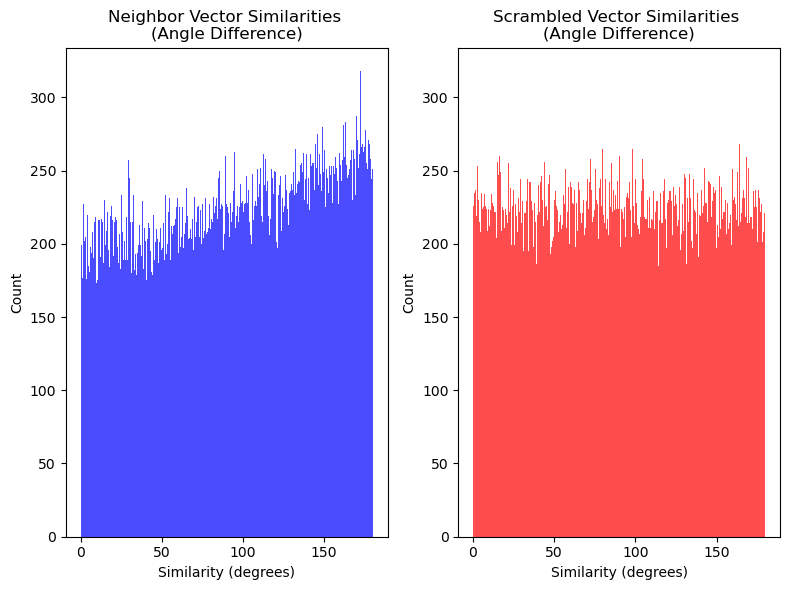

In [61]:
# now plot histogram of pairwise neighbor velocity similarities and scrambled version
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.hist(pairwise_neighbor_velocity_similarity, bins=500, color='blue', alpha=0.7)
plt.title('Neighbor Vector Similarities \n(' + similarity_metric.replace('_', ' ').title() + ')')
plt.xlabel('Similarity' + (' (degrees)' if similarity_metric == 'angle_difference' else ''))
plt.ylabel('Count')
#plt.xlim(0, 0.1)
y_limits = plt.ylim()  # get y limits to use for right plot
plt.subplot(1, 2, 2)
plt.hist(scrambled_pairwise_neighbor_velocity_similarity, bins=500, color='red', alpha=0.7)
plt.title('Scrambled Vector Similarities \n(' + similarity_metric.replace('_', ' ').title() + ')')
plt.xlabel('Similarity' + (' (degrees)' if similarity_metric == 'angle_difference' else ''))
plt.ylabel('Count')
#plt.xlim(0, 0.1)
# same y lim as left plot
plt.ylim(y_limits)
plt.tight_layout()
plt.savefig(output_fig_dir + f'pairwise_neighbor_velocity_similarity_histograms_{similarity_metric}.png')
plt.show()

In [ ]:
# 3-way ANOVA tests for PPR across IPI, Stim_Loc, and ROI_Loc
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for metric in ['PPHW', 'PPR', 'PPL']:
    for hn in ['Home', 'Neighbor']:
        hn_df = ppr_df[ppr_df['Home_Neighbor'] == hn]

        # filter nan from hn_df
        hn_df = hn_df.dropna(subset=[metric, 'IPI', 'Stim_Layer', 'HN_ROI_Loc'])
        
        model = ols(f'{metric} ~ C(IPI) + C(Stim_Layer) + C(HN_ROI_Loc) + C(IPI):C(Stim_Layer) + C(IPI):C(HN_ROI_Loc) + C(Stim_Layer):C(HN_ROI_Loc)', data=hn_df).fit()
        anova_table = anova_lm(model, typ=2)
        print(f"ANOVA results for {metric} {hn}:")
        print(anova_table)
        
        # significant differences to further test
        sig_diffs = {
            'Home': ['IPI', 'Stim_Layer', 'HN_ROI_Loc', 'Stim_Layer:HN_ROI_Loc'],
            'Neighbor': ['Stim_Layer', 'IPI:Stim_Layer', 'IPI:HN_ROI_Loc']
        }
        for s_diff in sig_diffs[hn]:
            print(f"Tukey's HSD test for {s_diff} in {hn}:")
            if ':' not in s_diff:
                # Tukey's HSD test for multiple comparisons
                
                tukey = pairwise_tukeyhsd(endog=hn_df[metric],
                                        groups=hn_df[s_diff], alpha=0.05)
                print(tukey)
            else:
                # double interaction terms require different handling
                # make a column that is the two columns appended
                cols = s_diff.split(':')
                hn_df[s_diff] = hn_df[cols[0]].astype(str) + "_" + hn_df[cols[1]].astype(str)
                # make nested groups for Tukey
                tukey = pairwise_tukeyhsd(endog=hn_df[metric],
                                        groups=hn_df[s_diff], alpha=0.05)
                print(tukey)

    model = ols(f'{metric} ~ C(IPI) + C(Stim_Layer) + C(HN_ROI_Loc) + C(IPI):C(Stim_Layer) + C(IPI):C(HN_ROI_Loc) + C(Stim_Layer):C(HN_ROI_Loc)', data=ppr_df).fit()
    anova_table = anova_lm(model, typ=2)
    print(f"ANOVA results for metric {metric} both:")
    print(anova_table)


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


ANOVA results for PPHW Home:
                                   sum_sq      df          F        PR(>F)
C(IPI)                        1695.143221     9.0  16.695749  4.025463e-19
C(Stim_Layer)                  461.110324     2.0  20.436987  1.473586e-09
C(HN_ROI_Loc)                  151.790666     2.0   6.727552  1.210752e-03
C(IPI):C(Stim_Layer)           736.419714    18.0   3.626560  4.969813e-06
C(IPI):C(HN_ROI_Loc)           501.843276    18.0   2.471369  5.172805e-04
C(Stim_Layer):C(HN_ROI_Loc)    942.839153     4.0  20.893906  4.543786e-17
Residual                     46151.673968  4091.0        NaN           NaN
Tukey's HSD test for IPI in Home:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  20.0   30.0  -2.2645    0.9  -7.1329  2.6038  False
  20.0   40.0  -0.1768    0.9  -5.0452  4.6915  False
  20.0   50.0  -1.2975  0.001  -1.7587 -0.8363   True
  20.0   60.0

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


ANOVA results for PPHW Neighbor:
                                    sum_sq      df         F    PR(>F)
C(IPI)                          213.281299     9.0  1.336426  0.236943
C(Stim_Layer)                   265.493802     2.0  7.486157  0.000566
C(HN_ROI_Loc)                   209.383239     2.0  5.904002  0.002744
C(IPI):C(Stim_Layer)           1112.502933    18.0  3.485485  0.000010
C(IPI):C(HN_ROI_Loc)            368.721841    18.0  1.155210  0.290374
C(Stim_Layer):C(HN_ROI_Loc)     316.563809     4.0  4.463092  0.001333
Residual                     106056.977222  5981.0       NaN       NaN
Tukey's HSD test for Stim_Layer in Neighbor:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  L2/3     L4  -0.2449 0.1803 -0.5695 0.0796  False
  L2/3     L5   0.2469 0.1813 -0.0809 0.5747  False
    L4     L5   0.4919  0.001  0.1771 0.8066   True
------------------------------------------

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 44
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints doe

ANOVA results for metric PPHW both:
                                    sum_sq       df          F        PR(>F)
C(IPI)                         7183.768111      9.0  52.820887  2.080321e-94
C(Stim_Layer)                   694.582763      2.0  22.982110  1.100726e-10
C(HN_ROI_Loc)                   531.318430      5.0   7.032031  1.195013e-05
C(IPI):C(Stim_Layer)           1607.393097     18.0   5.909429  9.940606e-12
C(IPI):C(HN_ROI_Loc)           1381.137488     45.0   2.031049  6.691408e-05
C(Stim_Layer):C(HN_ROI_Loc)    1290.142658     10.0   8.537557  5.102973e-14
Residual                     152352.925237  10082.0        NaN           NaN
ANOVA results for PPR Home:
                                 sum_sq      df          F        PR(>F)
C(IPI)                         4.432973     9.0   2.613774  2.288703e-02
C(Stim_Layer)                  6.845239     2.0  18.162433  1.401390e-08
C(HN_ROI_Loc)                  1.455244     2.0   3.861192  2.111873e-02
C(IPI):C(Stim_Layer)        

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
100.0_L2/3   100.0_L4  -0.0628    0.9 -0.1998  0.0741  False
100.0_L2/3   100.0_L5  -0.0818 0.8517 -0.2194  0.0558  False
100.0_L2/3 150.0_L2/3   -0.065    0.9  -0.609  0.4789  False
100.0_L2/3   150.0_L4  -0.0789    0.9 -0.6548  0.4969  False
100.0_L2/3   150.0_L5   -0.166    0.9   -0.71  0.3779  False
100.0_L2/3  20.0_L2/3   0.0118    0.9 -0.1294   0.153  False
100.0_L2/3    20.0_L4   0.1027 0.4823 -0.0344  0.2397  False
100.0_L2/3    20.0_L5  -0.0159    0.9 -0.1534  0.1215  False
100.0_L2/3 200.0_L2/3   0.3208  0.001  0.1576   0.484   True
100.0_L2/3   200.0_L4   0.3012  0.001  0.1452  0.4571   True
100.0_L2/3   200.0_L5   0.1667 0.0273  0.0078  0.3256   True
100.0_L2/3    30.0_L4   0.0969    0.9 -0.6274  0.8212  False
100.0_L2/3    40.0_L4  -0.0091    0.9 -0.7334  0.7152  False
100.0_L2/3  50.0_L2/3  -

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does 

ANOVA results for metric PPR both:
                                  sum_sq       df          F        PR(>F)
C(IPI)                         84.251380      9.0  29.886187  1.296414e-46
C(Stim_Layer)                  13.674073      2.0  21.827495  3.471416e-10
C(HN_ROI_Loc)                  10.699201      5.0   6.831520  1.734756e-05
C(IPI):C(Stim_Layer)           11.719108     18.0   2.078538  1.020765e-02
C(IPI):C(HN_ROI_Loc)           12.900389     45.0   0.915222  6.321059e-01
C(Stim_Layer):C(HN_ROI_Loc)    15.304331     10.0   4.885965  4.501687e-07
Residual                     3220.635742  10282.0        NaN           NaN
ANOVA results for PPL Home:
                                   sum_sq      df         F        PR(>F)
C(IPI)                         216.773697     9.0  8.982106  4.989273e-11
C(Stim_Layer)                   16.885700     2.0  3.148496  4.302789e-02
C(HN_ROI_Loc)                    3.901092     2.0  0.727395  4.832329e-01
C(IPI):C(Stim_Layer)           133.775764

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
100.0_L2/3   100.0_L4   0.1456    0.9 -0.2631  0.5543  False
100.0_L2/3   100.0_L5   0.4614   0.01  0.0507  0.8721   True
100.0_L2/3 150.0_L2/3   0.7798    0.9 -0.7985  2.3582  False
100.0_L2/3   150.0_L4  -0.5328    0.9 -2.2036   1.138  False
100.0_L2/3   150.0_L5  -0.7229    0.9 -2.3012  0.8555  False
100.0_L2/3  20.0_L2/3  -1.6765  0.001 -2.1581 -1.1949   True
100.0_L2/3    20.0_L4  -1.2102  0.001 -1.6495 -0.7709   True
100.0_L2/3    20.0_L5  -1.1427  0.001 -1.5922 -0.6932   True
100.0_L2/3 200.0_L2/3  -0.0812    0.9 -0.5594   0.397  False
100.0_L2/3   200.0_L4  -0.2265    0.9 -0.6887  0.2357  False
100.0_L2/3   200.0_L5  -0.0072    0.9  -0.476  0.4616  False
100.0_L2/3    30.0_L4  -2.0396 0.6239 -4.9957  0.9165  False
100.0_L2/3    40.0_L4  -2.0568 0.1814 -4.4009  0.2873  False
100.0_L2/3  50.0_L2/3  -

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 44
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# save final dataframe to CSV
output_csv = output_fig_dir + 'ppr_analysis_raw_data.csv'
ppr_df.to_csv(output_csv, index=False)

In [ ]:
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
model = ols('PPR ~ IPI + C(Medial_Lateral) + IPI:C(Medial_Lateral)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Section'] == 'Coronal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

KeyError: 'Medial_Lateral'

In [ ]:
# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

In [ ]:
# load all_animals_age_sex.csv from C:\Users\jjudge3\Desktop\Data\crossing_PPR\
age_sex_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_animals_age_sex.csv'
age_sex_df = pd.read_csv(age_sex_csv)

# add age and sex as columns to ladder_df_nbqx, matching on Date
# Merge Age and Sex from age_sex_df into ppr_final_df using the Date column
ppr_final_df = ppr_final_df.merge(
    age_sex_df[['Date', 'Age', 'Sex']],
    on='Date',
    how='left',
    suffixes=('', '_from_age_sex')
)
ppr_final_df

In [ ]:
# ANOVA for age
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
# make Age_from_age_sex a numerical column
ppr_final_df['Age_from_age_sex'] = pd.to_numeric(ppr_final_df['Age_from_age_sex'], errors='coerce')
model = ols('PPR ~ IPI + Age_from_age_sex + Sex + IPI:Age_from_age_sex + IPI:Sex + Direction', 
                data=ppr_final_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

In [ ]:
# Group by Sex and then plot PPR versus IPI.

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Iterate through each unique Sex value
for i_sex, sex in enumerate(ppr_final_df['Sex'].unique()):
    # Filter the DataFrame for the current sex, and for Direction not None
    sex_ppr_df = ppr_final_df[(ppr_final_df['Sex'] == sex)]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = sex_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color='tab:red' if sex == 'M' else 'tab:purple',
                label = sex, fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color='tab:red' if sex == 'M' else 'tab:purple', linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Sex: {sex} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")
    
    # print number of animals
    print(sex_ppr_df[['Date']].drop_duplicates())
    n_slices = sex_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Sex: {sex} | n: {n_slices}")

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "sex_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Group by Age and then plot PPR versus IPI.

# map ages to the nearest of 30, 45, or 60 days
def map_age_to_nearest(age):
    if age < 37.5:
        return 30
    elif 37.5 < age < 52.5:
        return 45
    elif age > 52.5:
        return 60
    else:
        return 60
# Apply the mapping function to the Age column
ppr_final_df['Age'] = ppr_final_df['Age'].apply(map_age_to_nearest)

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# colorbar for age
# Normalize ages for colormap
ages = ppr_final_df['Age'].unique()
ages.sort()
norm = plt.Normalize(ages.min(), ages.max())
cmap = plt.cm.viridis

# Iterate through each unique Sex value
for i_age, age in enumerate(ppr_final_df['Age'].unique()):
    # Filter the DataFrame for the current sex
    age_ppr_df = ppr_final_df[ppr_final_df['Age'] == age]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = age_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars

    # Get color for this age
    color = cmap(norm(age))
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                fmt='o')


    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                 fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color=color, linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Age: {age} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")

    # print number of animals
    n_slices = age_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Age: {age} | n: {n_slices}")


# Add colorbar to indicate age
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Age (days)')

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "age_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# use ttest_ind_from_stats to see if PPR linear regression slopes/intercepts are significantly different
# in age groups or between sexes

'''Age: 45 | Slope: 0.0007 ± 0.0006 | Intercept: 0.7538 ± 0.0495
Age: 45 | n: 9
Age: 60 | Slope: 0.0007 ± 0.0005 | Intercept: 0.6980 ± 0.0384
Age: 60 | n: 2
Age: 30 | Slope: 0.0029 ± 0.0020 | Intercept: 0.6745 ± 0.1627
Age: 30 | n: 1'''

slope_means = {
    'M': 0.0015,
    'F': 0.0003,
    '30': 0.0029,
    '45': 0.0007,
    '60': 0.0007,
}
slope_stds = {
    'M': 0.0006,
    'F': 0.0007,
    '30': 0.0020,
    '45': 0.0006,
    '60': 0.0005,
}
intercept_means = {
    'M': 0.6667,
    'F': 0.7934,
    '30': 0.6745,
    '45': 0.7538,
    '60': 0.6980
}
intercept_stds = {
    'M': 0.0536,
    'F': 0.0547,
    '30': 0.1627,
    '45': 0.0495,
    '60': 0.0384
}

sample_sizes = {
    'M': 8,
    'F': 4,
    '30': 1,
    '45': 9,
    '60': 2
}


# calculate the t-statistic and p-value for each pair of slopes and intercepts
slope_tstat, slope_pval = ttest_ind_from_stats(slope_means['M'], slope_stds['M'], sample_sizes['M'], 
                                                slope_means['F'], slope_stds['F'], sample_sizes['F'],
                                                equal_var=False)
intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means['M'], intercept_stds['M'], sample_sizes['M'], 
                                                        intercept_means['F'], intercept_stds['F'], sample_sizes['F'],
                                                        equal_var=False)
print(f"\nM vs F:")
print("Slope t-statistic =", round(slope_tstat, 2))
print("Slope p-value =", slope_pval)
print("Intercept t-statistic =", round(intercept_tstat, 2))
print("Intercept p-value =", intercept_pval)


# calculate the t-statistic and p-value for each pair of slopes and intercepts
ages = ['45', '60']
for i1 in range(len(ages)):
    age1 = ages[i1]
    for i2 in range(i1+1, len(ages)):
        age2 = ages[i2]
        if age1 == age2:
            continue
        slope_tstat, slope_pval = ttest_ind_from_stats(slope_means[age1], slope_stds[age1], sample_sizes[age1], 
                                                        slope_means[age2], slope_stds[age2], sample_sizes[age2],
                                                        equal_var=False)
        intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means[age1], intercept_stds[age1], sample_sizes[age1], 
                                                                intercept_means[age2], intercept_stds[age2], sample_sizes[age2],
                                                                equal_var=False)
        print(f"\n{age1} vs {age2}:")
        print("Slope t-statistic =", round(slope_tstat, 2))
        print("Slope p-value =", slope_pval)
        print("Intercept t-statistic =", round(intercept_tstat, 2))
        print("Intercept p-value =", intercept_pval)


## 